# Notebook precipitation forecast 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

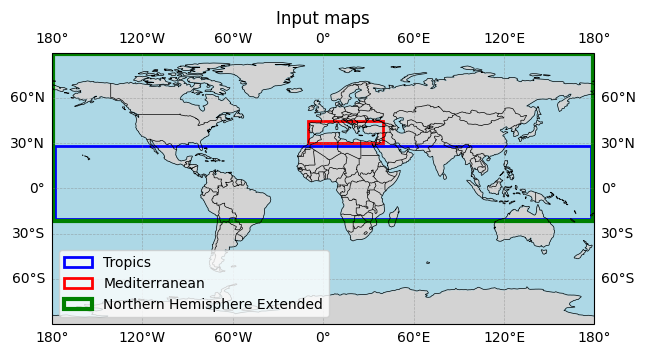

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a new figure and axes with a Plate Carree projection
fig, ax = plt.subplots(figsize=(7, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Add colored land and ocean features
ax.add_feature(cfeature.LAND, facecolor='lightgrey', edgecolor='face')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', edgecolor='face')

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Define the regions
tropics = plt.Rectangle((-178, -20), 356, 48, fill=False, color='blue', linewidth=2, transform=ccrs.PlateCarree())
mediterranean = plt.Rectangle((-10, 30), 50, 15, fill=False, color='red', linewidth=2, transform=ccrs.PlateCarree())
northern_hemisphere_extended = plt.Rectangle((-179, -21.5), 358, 110.5, fill=False, color='green', linewidth=3, transform=ccrs.PlateCarree())

# Add the regions to the map
ax.add_patch(tropics)
ax.add_patch(mediterranean)
ax.add_patch(northern_hemisphere_extended)

# Add a legend
ax.legend([tropics, mediterranean, northern_hemisphere_extended], 
          ['Tropics', 'Mediterranean', 'Northern Hemisphere Extended'],
          loc='lower left')

# Set the map extent
ax.set_global()

# Show the plot
plt.title('Input maps')
plt.show()

In [5]:
from scipy import stats

In [6]:
import time

def default_save_name():
    now = time.strftime("%Y%m%d_%H%M%S")
    return f"earthformer_era_{now}"

default_save_name()


'earthformer_era_20240927_111901'

In [2]:
dataset_path = "/home/egauillard/data/PR_era5_MED_1degr_19400101_20240229_new.nc"

In [3]:
ds = xr.open_dataset(f"{dataset_path}")
daily_precip = ds["tp"]*1000

daily_precip.values.mean()

1.480356

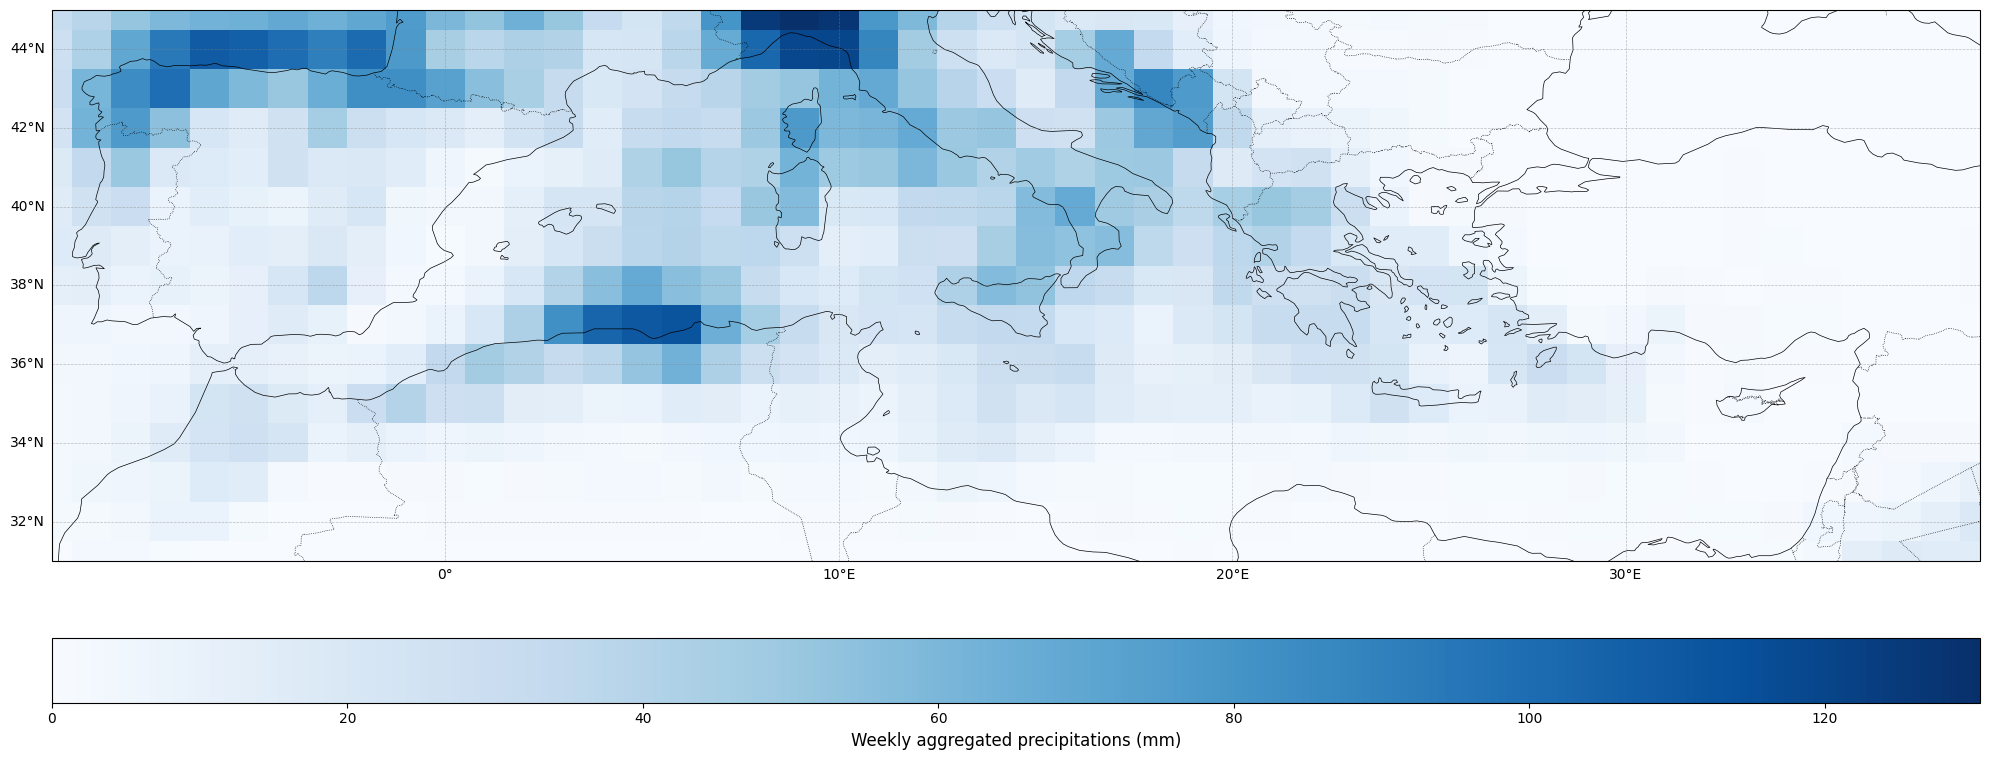

In [22]:
import cartopy.feature as cfeature
# plot the precipitation using cartopy
sample = daily_precip.isel(time=range(61579,61586)).sum(dim='time')

# Créer le plot
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# Tracer les données
im = ax.pcolormesh(sample.longitude, sample.latitude, sample.values,
                   transform=ccrs.PlateCarree(), cmap='Blues')

# Ajouter les côtes et les frontières
ax.coastlines(resolution='50m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax

# Ajouter les lignes de grille principales
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Obtenir la résolution des données
lat_res = np.abs(sample.latitude[1] - sample.latitude[0])
lon_res = np.abs(sample.longitude[1] - sample.longitude[0])

# Ajouter des lignes de grille mineures pour montrer les cellules individuelles
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
             linewidth=0.01, color='gray', alpha=0.2, linestyle=':',
             xlocs=np.arange(sample.longitude.min(), sample.longitude.max() + lon_res, lon_res),
             ylocs=np.arange(sample.latitude.min(), sample.latitude.max() + lat_res, lat_res))

# Définir les limites de la carte pour montrer seulement la zone de sample
ax.set_extent([sample.longitude.min(), sample.longitude.max(), 
               sample.latitude.min(), sample.latitude.max()], 
              crs=ccrs.PlateCarree())

# Ajouter une barre de couleur
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Weekly aggregated precipitations (mm)', fontsize=12)

plt.tight_layout()
plt.show()


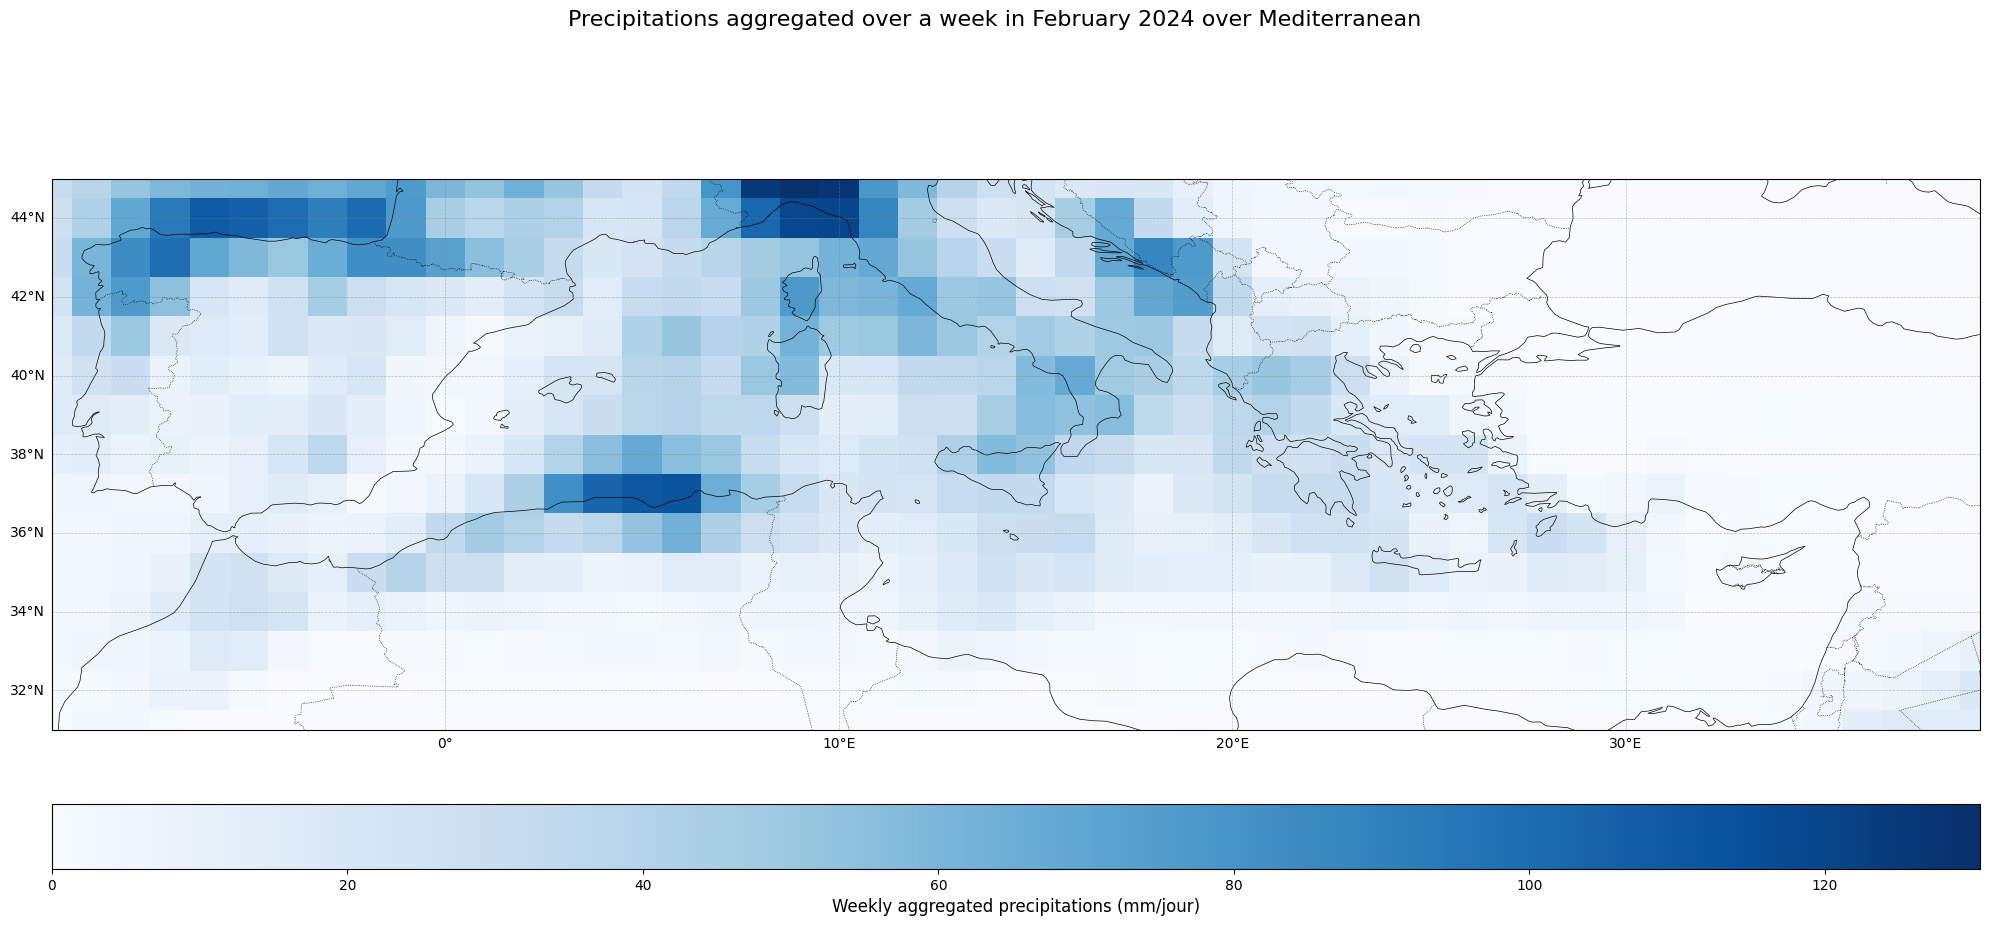

In [10]:
np.unique(daily_precip.time.dt.week)

/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:440: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53])

In [ ]:
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration du style Seaborn
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def get_weekly_precipitation(data):
    # Group by week and sum across all dimensions
    weekly_data = data.groupby('time.week').sum(dim=['time', 'latitude', 'longitude'])
    return weekly_data.values.flatten()

# Get weekly precipitation data
weekly_precip = get_weekly_precipitation(daily_precip)

# Fit gamma distribution
shape, loc, scale = stats.gamma.fit(weekly_precip)

# Create DataFrame for plotting
df = pd.DataFrame({'Weekly Precipitation': weekly_precip})

# Plot the distribution
plt.figure(figsize=(14, 10))
sns.histplot(data=df, x='Weekly Precipitation', stat='density', kde=True, color='skyblue', label='Data')
x = np.linspace(0, weekly_precip.max(), 100)
y = stats.gamma.pdf(x, shape, loc, scale)
plt.plot(x, y, color='red', lw=2, label='Fitted Gamma')
plt.xlabel('Weekly Precipitation Sum (mm)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Weekly Precipitation Sums', fontsize=16)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('weekly_precipitation_distribution.png')
plt.close()

# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.kstest(weekly_precip, 'gamma', args=(shape, loc, scale))
print(f"Kolmogorov-Smirnov test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")

# Q-Q plot
fig, ax = plt.subplots(figsize=(12, 10))
stats.probplot(weekly_precip, dist=stats.gamma(shape, loc, scale), plot=ax)
ax.set_title("Q-Q plot for Weekly Precipitation", fontsize=16)
sns.despine()
plt.tight_layout()
plt.savefig('weekly_precipitation_qq_plot.png')
plt.close()

# Visualize distribution parameters
param_df = pd.DataFrame({
    'Parameter': ['Shape', 'Location', 'Scale'],
    'Value': [shape, loc, scale]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Parameter', y='Value', data=param_df, palette='viridis')
plt.title('Gamma Distribution Parameters for Weekly Precipitation', fontsize=16)
plt.ylabel('Value')
sns.despine()
plt.tight_layout()
plt.savefig('weekly_precipitation_gamma_params.png')
plt.close()

# Calculate and print some statistics
mean_weekly_precip = np.mean(weekly_precip)
median_weekly_precip = np.median(weekly_precip)
std_weekly_precip = np.std(weekly_precip)

print(f"Mean weekly precipitation: {mean_weekly_precip:.2f} mm")
print(f"Median weekly precipitation: {median_weekly_precip:.2f} mm")
print(f"Standard deviation of weekly precipitation: {std_weekly_precip:.2f} mm")

# Save the weekly precipitation data
np.savetxt('weekly_precipitation_data.csv', weekly_precip, delimiter=',')
print("Weekly precipitation data saved to 'weekly_precipitation_data.csv'")

<xarray.DataArray 'tp' (time: 1176)>
array([0.26103765, 0.31126943, 0.2523001 , ..., 0.24280381, 0.15156701,
       0.21983033], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1940-07-22T12:00:00 ... 2023-07-30T12:00:00
Attributes:
    long_name:     Total precipitation
    units:         m
    cell_methods:  time: sum


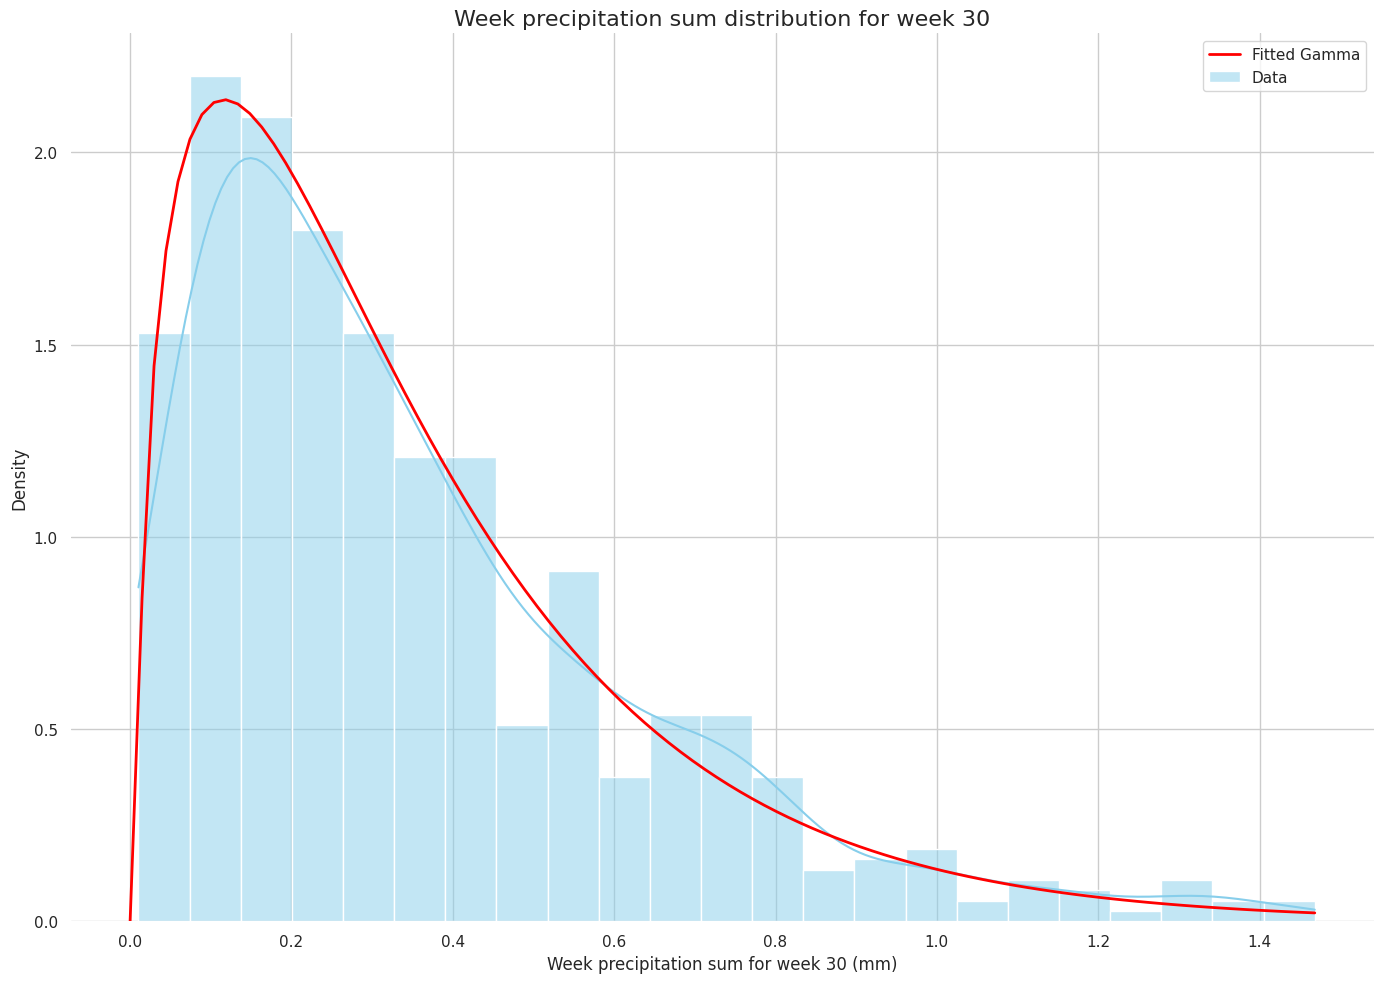

Kolmogorov-Smirnov test: statistic=0.0223, p-value=0.5927


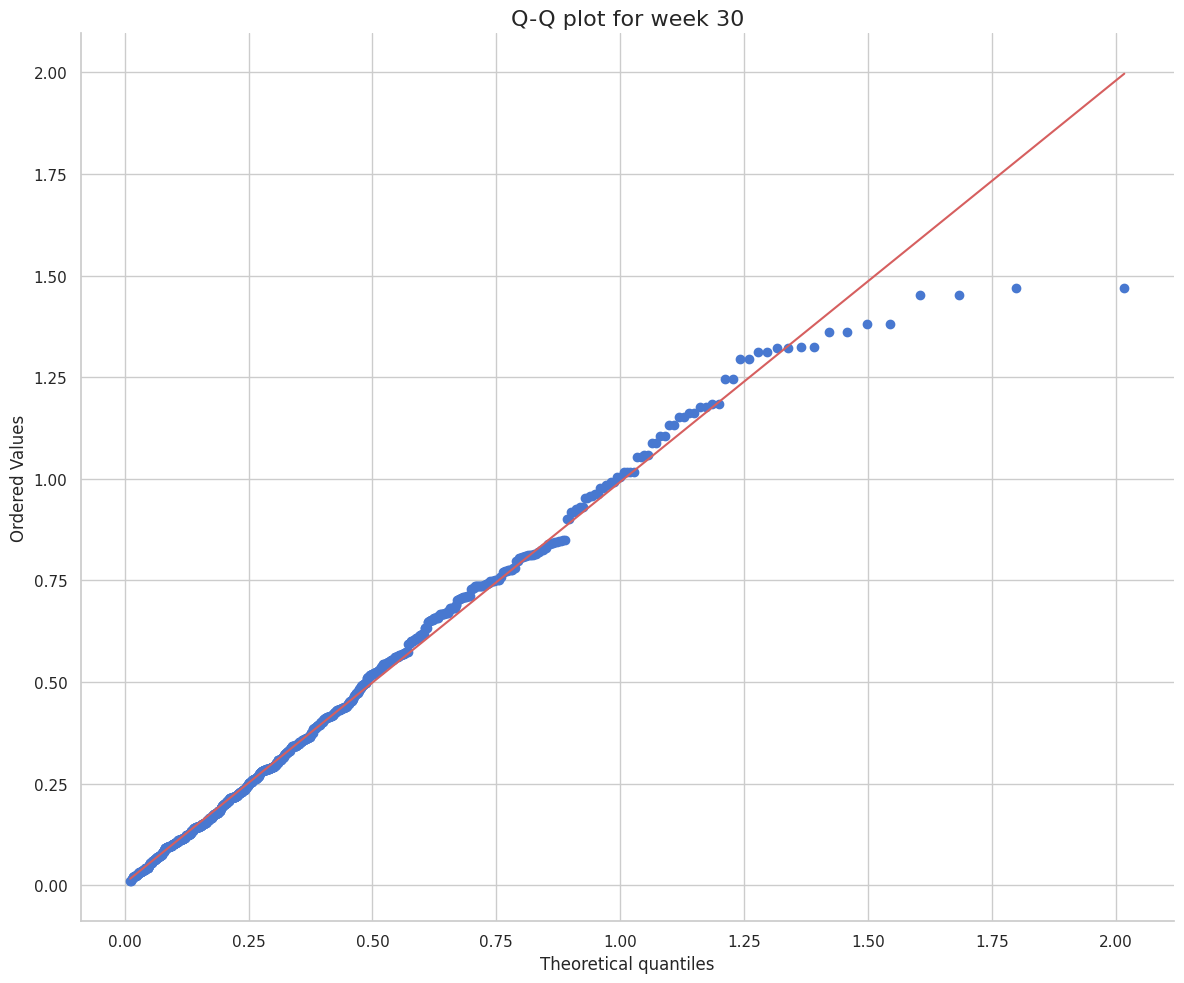

/scratch-local/69627/ipykernel_2176796/2983347907.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Parameter', y='Value', data=param_df, palette='viridis')


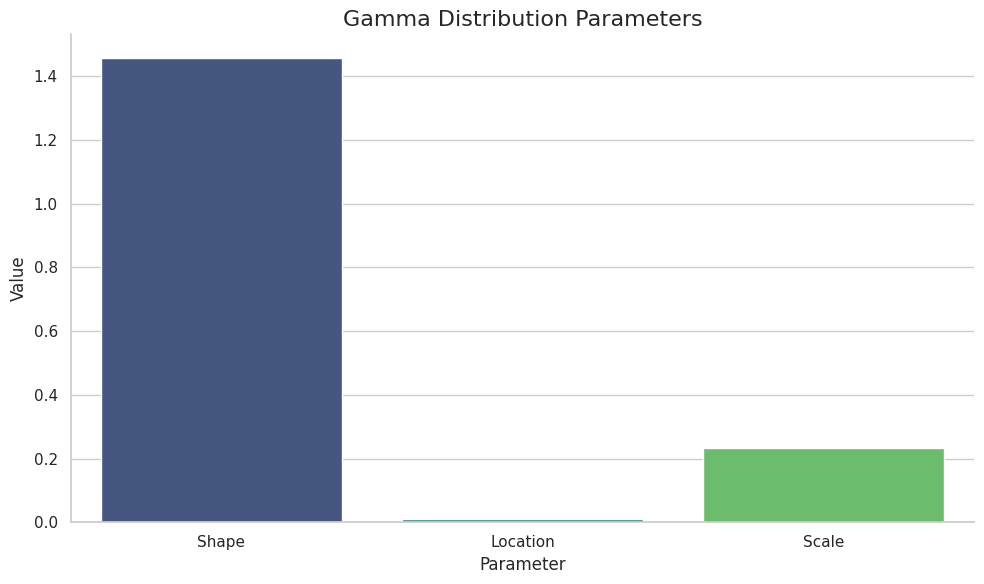

In [11]:
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration du style Seaborn
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def get_week_distribution(data, week_number):
    week_data = data.sel(time=data.time.dt.isocalendar().week == week_number)
    two_week_sum = week_data.groupby('time.year').sum(dim = ['latitude', 'longitude'])
    print(two_week_sum)
    return two_week_sum.values.flatten()

week_number = 30
week_data = get_week_distribution(daily_precip, week_number)

# Ajustement de la distribution gamma
shape, loc, scale = stats.gamma.fit(week_data)
x = np.linspace(0, week_data.max(), 100)
y = stats.gamma.pdf(x, shape, loc, scale)

# Création d'un DataFrame pour Seaborn
df = pd.DataFrame({'Precipitation': week_data})

# Visualisation avec Seaborn
plt.figure(figsize=(14, 10))
sns.histplot(data=df, x='Precipitation', stat='density', kde=True, color='skyblue', label='Data')
plt.plot(x, y, color='red', lw=2, label='Fitted Gamma')
plt.xlabel(f'Week precipitation sum for week {week_number} (mm)')
plt.ylabel('Density')

plt.legend()
plt.title(f'Week precipitation sum distribution for week {week_number}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Test de Kolmogorov-Smirnov
ks_statistic, p_value = stats.kstest(week_data, 'gamma', args=(shape, loc, scale))
print(f"Kolmogorov-Smirnov test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")

# Q-Q plot avec Seaborn
fig, ax = plt.subplots(figsize=(12, 10))
stats.probplot(week_data, dist=stats.gamma(shape, loc, scale), plot=ax)
ax.set_title(f"Q-Q plot for week {week_number}", fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

# Visualisation des paramètres de la distribution
param_df = pd.DataFrame({
    'Parameter': ['Shape', 'Location', 'Scale'],
    'Value': [shape, loc, scale]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Parameter', y='Value', data=param_df, palette='viridis')
plt.title('Gamma Distribution Parameters', fontsize=16)
plt.ylabel('Value')
sns.despine()
plt.tight_layout()
plt.show()

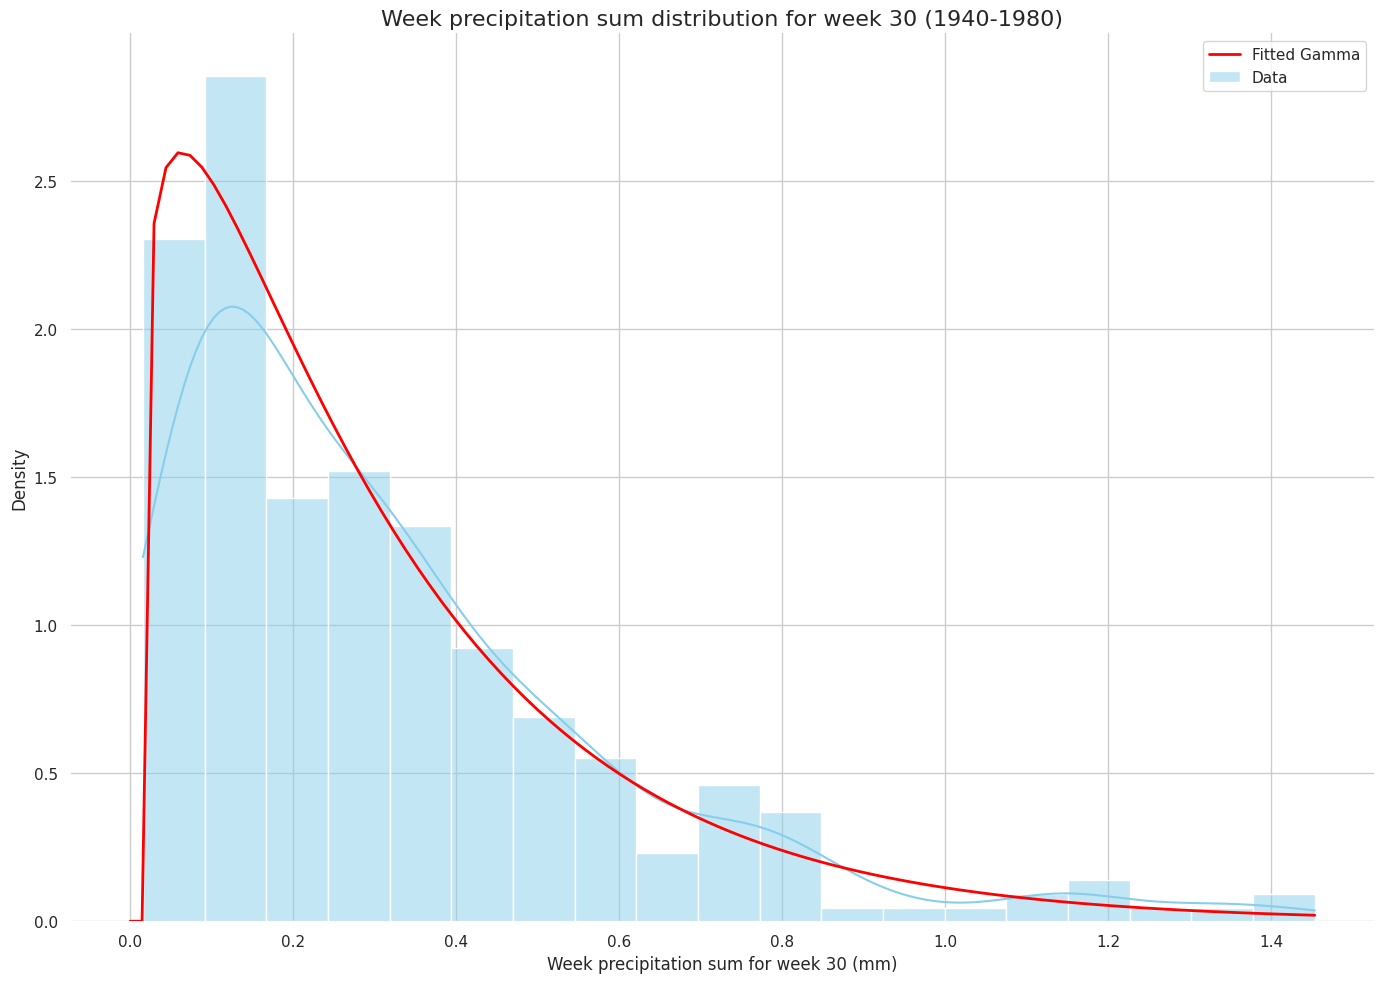

Kolmogorov-Smirnov test: statistic=0.0295, p-value=0.6899


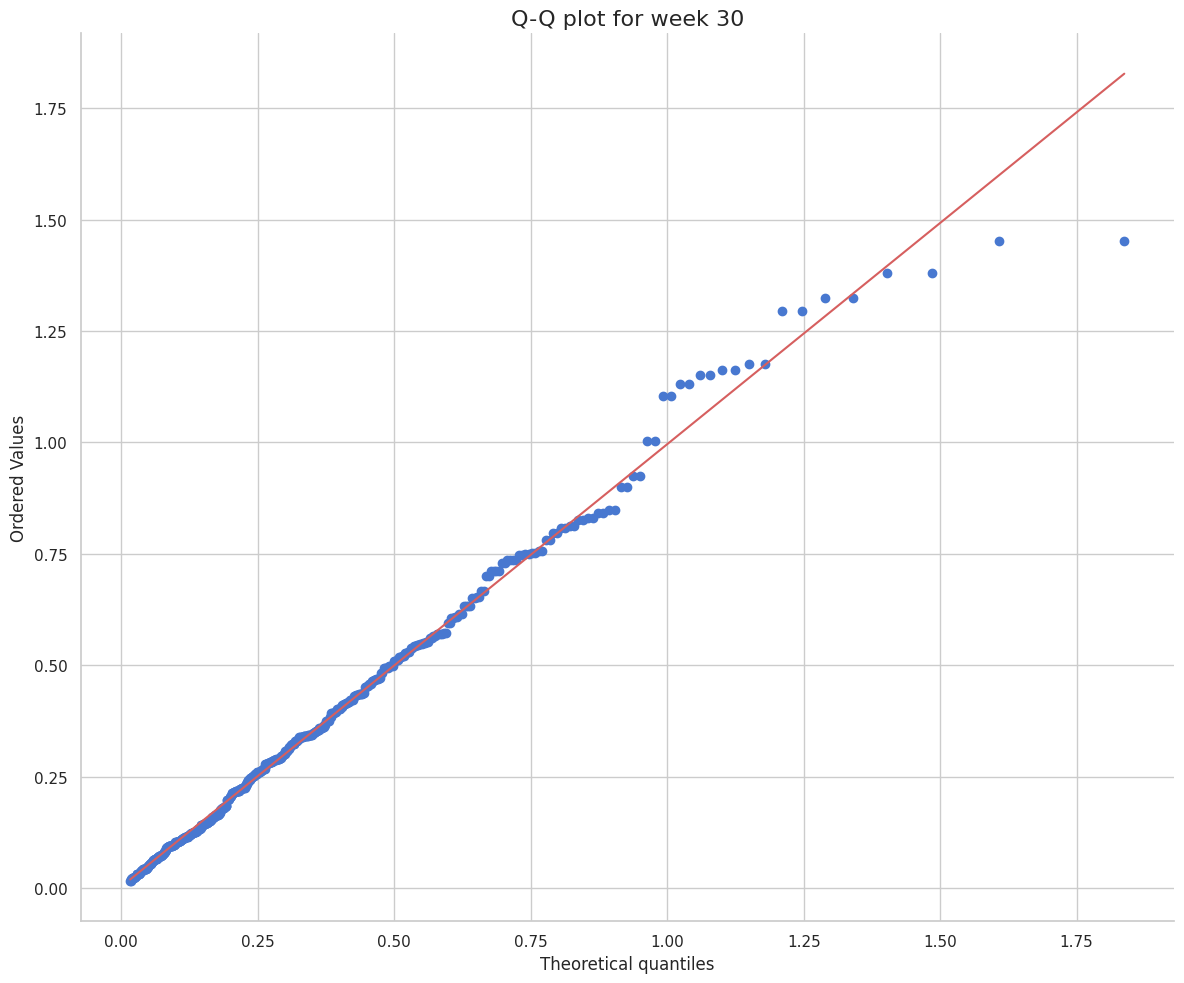

/scratch-local/69627/ipykernel_2176796/4128117122.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Parameter', y='Value', data=param_df, palette='viridis')


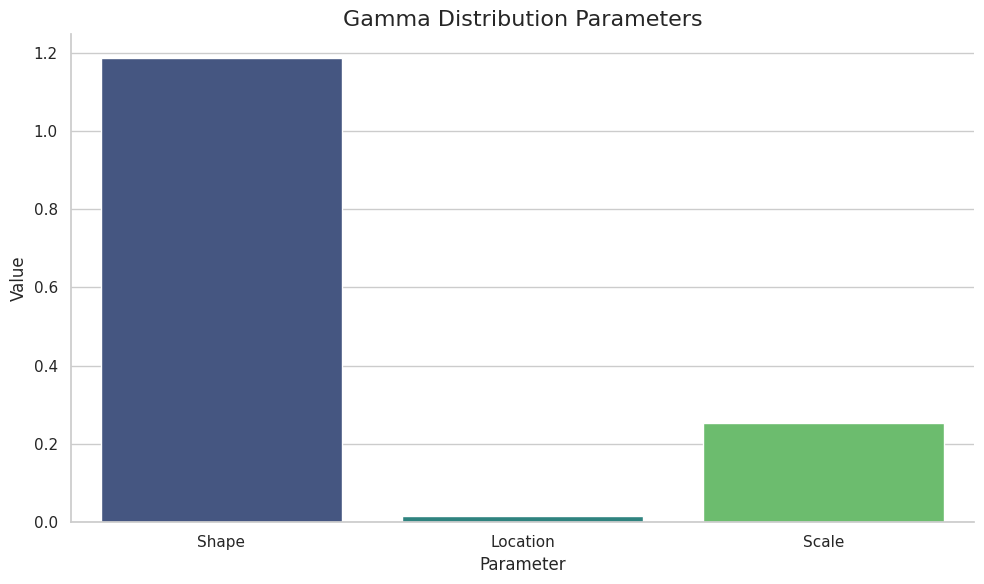

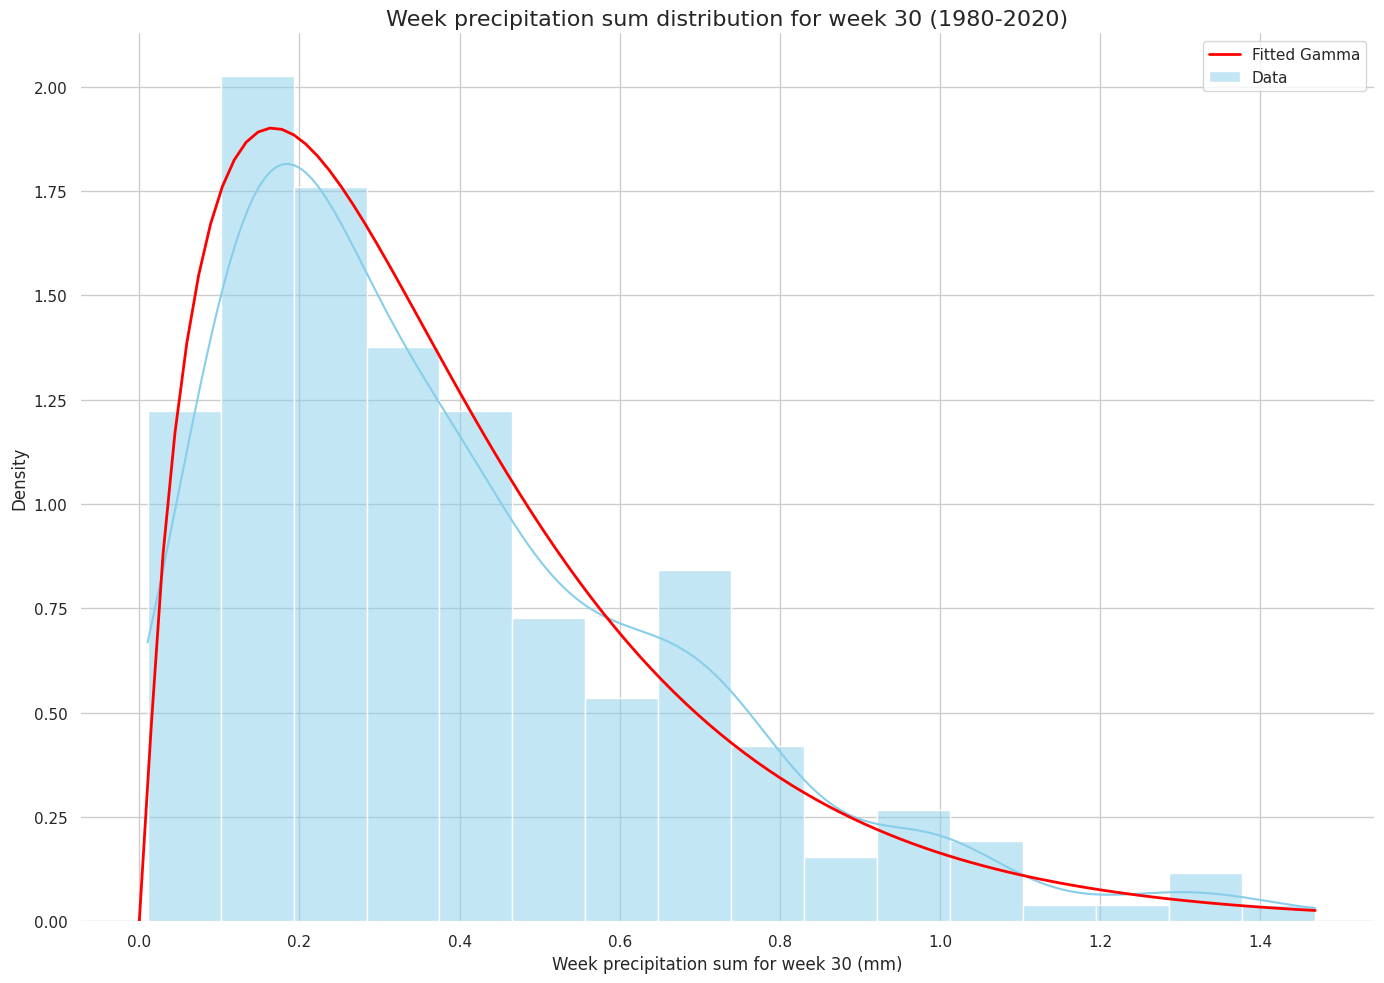

Kolmogorov-Smirnov test: statistic=0.0384, p-value=0.3568


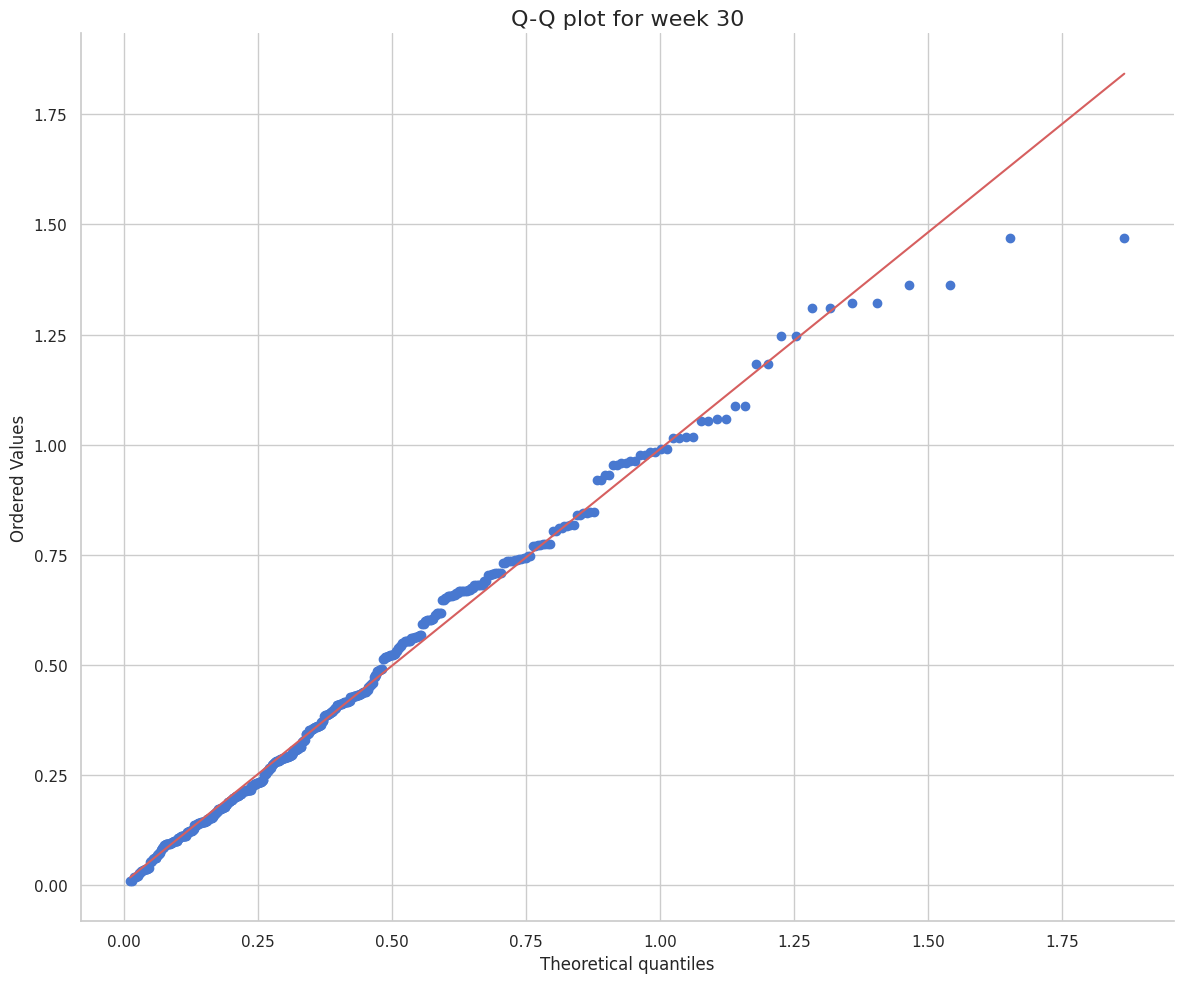

/scratch-local/69627/ipykernel_2176796/4128117122.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Parameter', y='Value', data=param_df, palette='viridis')


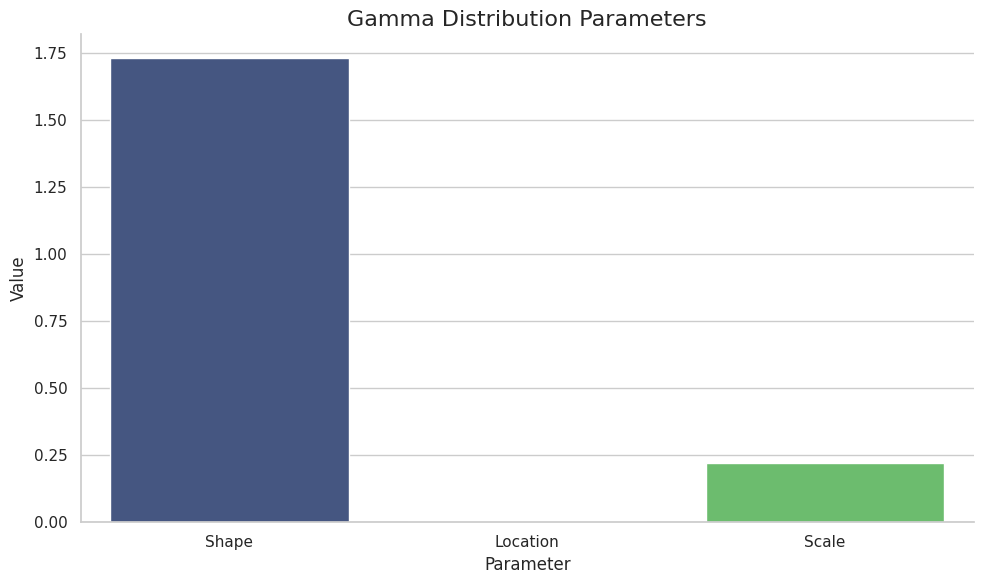

In [12]:
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration du style Seaborn
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def get_week_distribution(data, week_number):
    week_data = data.sel(time=data.time.dt.isocalendar().week == week_number)
    two_week_sum = week_data.groupby('time.year').sum(dim=['latitude', 'longitude'])
    return two_week_sum

def plot_distribution_and_fit(data, week_number, title):
    week_data = get_week_distribution(data, week_number)
    week_values = week_data.values.flatten()

    # Ajustement de la distribution gamma
    shape, loc, scale = stats.gamma.fit(week_values)
    x = np.linspace(0, week_values.max(), 100)
    y = stats.gamma.pdf(x, shape, loc, scale)

    # Création d'un DataFrame pour Seaborn
    df = pd.DataFrame({'Precipitation': week_values})

    # Visualisation avec Seaborn
    plt.figure(figsize=(14, 10))
    sns.histplot(data=df, x='Precipitation', stat='density', kde=True, color='skyblue', label='Data')
    plt.plot(x, y, color='red', lw=2, label='Fitted Gamma')
    plt.xlabel(f'Week precipitation sum for week {week_number} (mm)')
    plt.ylabel('Density')

    plt.legend()
    plt.title(title, fontsize=16)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

    # Test de Kolmogorov-Smirnov
    ks_statistic, p_value = stats.kstest(week_values, 'gamma', args=(shape, loc, scale))
    print(f"Kolmogorov-Smirnov test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")

    # Q-Q plot avec Seaborn
    fig, ax = plt.subplots(figsize=(12, 10))
    stats.probplot(week_values, dist=stats.gamma(shape, loc, scale), plot=ax)
    ax.set_title(f"Q-Q plot for week {week_number}", fontsize=16)
    sns.despine()
    plt.tight_layout()
    plt.show()

    # Visualisation des paramètres de la distribution
    param_df = pd.DataFrame({
        'Parameter': ['Shape', 'Location', 'Scale'],
        'Value': [shape, loc, scale]
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Parameter', y='Value', data=param_df, palette='viridis')
    plt.title('Gamma Distribution Parameters', fontsize=16)
    plt.ylabel('Value')
    sns.despine()
    plt.tight_layout()
    plt.show()

# Charger les données
daily_precip = xr.open_dataset(dataset_path)["tp"] # Remplacez par le chemin de votre fichier

# Assurez-vous que l'index temporel est monotone croissant
daily_precip = daily_precip.sortby('time')

# Sélection des périodes
data_1940_1980 = daily_precip.sel(time=slice('1940-01-01', '1980-12-31'))
data_1980_2020 = daily_precip.sel(time=slice('1980-01-01', '2020-12-31'))

week_number = 30

# Analyse pour 1940-1980
plot_distribution_and_fit(data_1940_1980, week_number, 'Week precipitation sum distribution for week 30 (1940-1980)')

# Analyse pour 1980-2020
plot_distribution_and_fit(data_1980_2020, week_number, 'Week precipitation sum distribution for week 30 (1980-2020)')


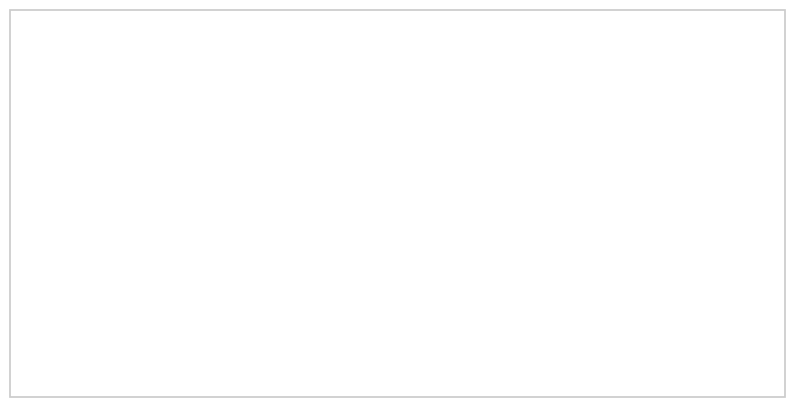

In [13]:
# Avec cartopy montrez la carte
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())


      month  latitude  longitude        tp
0         1      45.0      -10.0  0.003438
1         1      45.0       -9.0  0.003643
2         1      45.0       -8.0  0.003821
3         1      45.0       -7.0  0.003741
4         1      45.0       -6.0  0.003490
...     ...       ...        ...       ...
8995     12      31.0       35.0  0.000601
8996     12      31.0       36.0  0.000424
8997     12      31.0       37.0  0.000230
8998     12      31.0       38.0  0.000250
8999     12      31.0       39.0  0.000271

[9000 rows x 4 columns]


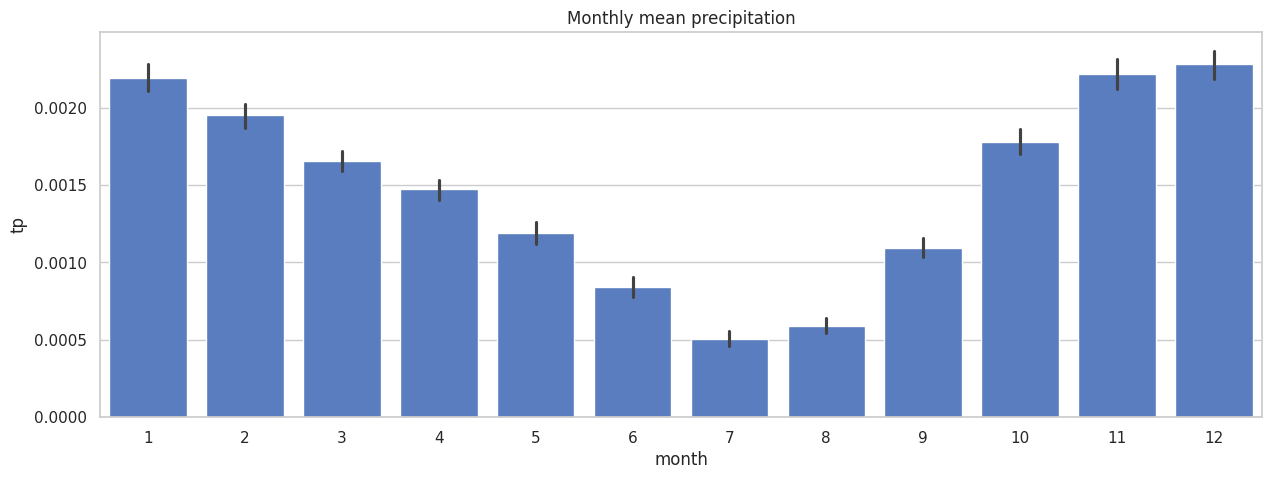

In [14]:
# plot la moyenne par mois de preciipitation average sur toute la mediterannee
monthly_mean = ds['tp'].groupby('time.month').mean(dim='time')
monthly_mean_df = monthly_mean.to_dataframe().reset_index()
print(monthly_mean_df)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(data=monthly_mean_df, x='month', y='tp', ax=ax)
plt.title('Monthly mean precipitation')
plt.show()

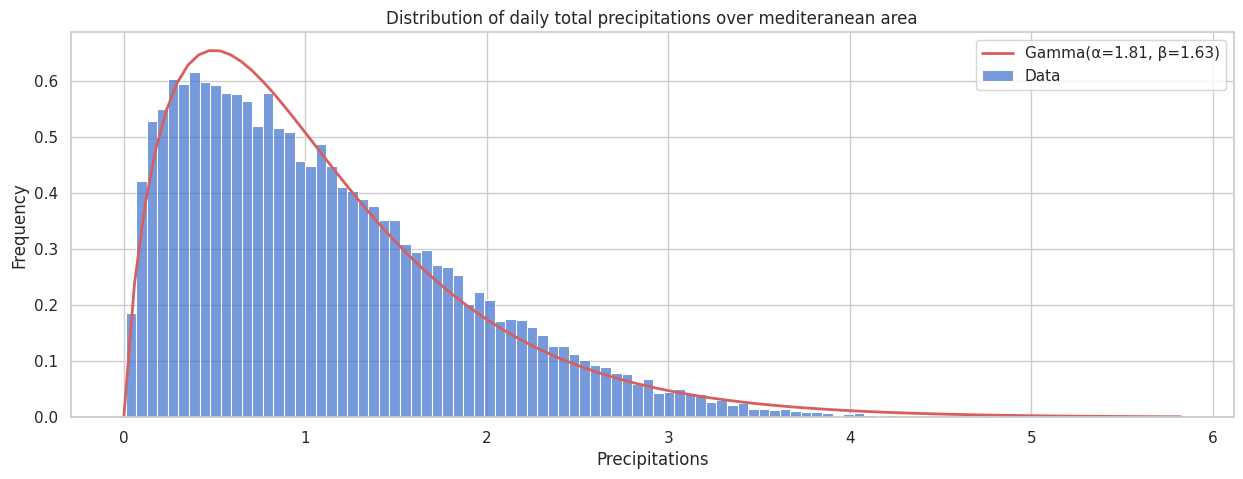

Paramètres de la distribution Gamma ajustée :
Shape (α) : 1.8067
Rate (β) : 1.6273


In [15]:
#moyenne spatiale pour chaque jour
daily_mean = ds['tp'].sum(dim=['latitude', 'longitude'])

daily_mean_df = daily_mean.to_dataframe().reset_index()



# Ajuster une distribution Gamma aux données
shape, loc, scale = stats.gamma.fit(daily_mean_df['tp'], floc=0)


x = np.linspace(0, daily_mean_df['tp'].max(), 100)
gamma_pdf = stats.gamma.pdf(x, shape, loc, scale)

# Créer le plot
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Tracer l'histogramme
sns.histplot(daily_mean_df['tp'], bins=100, kde=False, stat='density', ax=ax, label='Data')

# Tracer la distribution Gamma ajustée
ax.plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma(α={shape:.2f}, β={1/scale:.2f})')

# Configurer les labels et le titre
plt.xlabel('Precipitations')
plt.ylabel('Frequency')
plt.title("Distribution of daily total precipitations over mediteranean area") 

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

# Afficher les paramètres de la distribution Gamma ajustée
print(f"Paramètres de la distribution Gamma ajustée :")
print(f"Shape (α) : {shape:.4f}")
print(f"Rate (β) : {1/scale:.4f}")



C'est la somme sur toute l'espace de la mediterannée 

           time  longitude  latitude        tp
0    1940-01-07       35.0      35.0  0.060074
1    1940-01-14       35.0      35.0  0.093104
2    1940-01-21       35.0      35.0  0.043334
3    1940-01-28       35.0      35.0  0.102684
4    1940-02-04       35.0      35.0  0.124754
...         ...        ...       ...       ...
4387 2024-02-04       35.0      35.0  0.115901
4388 2024-02-11       35.0      35.0  0.012077
4389 2024-02-18       35.0      35.0  0.089813
4390 2024-02-25       35.0      35.0  0.009034
4391 2024-03-03       35.0      35.0  0.000093

[4392 rows x 4 columns]


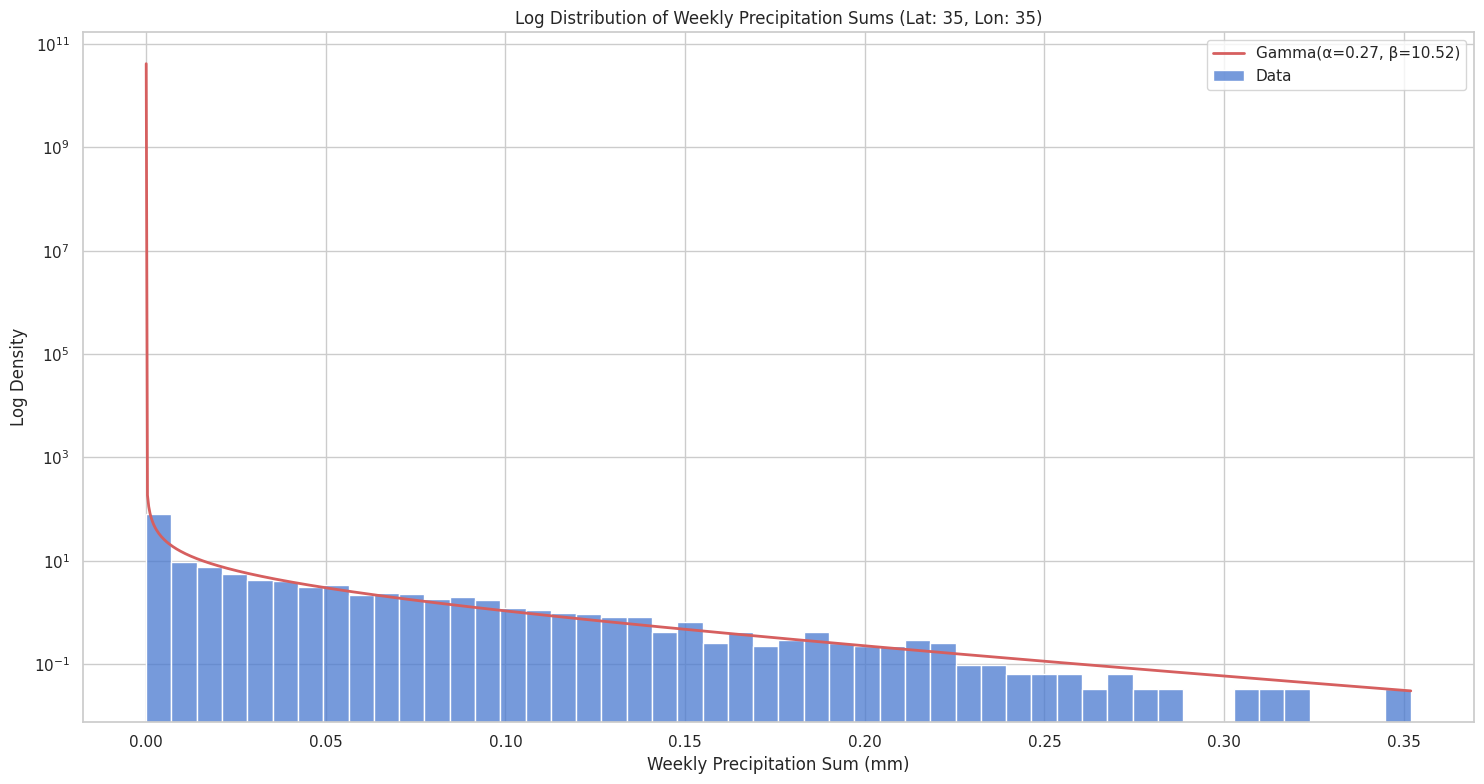

Parameters of the fitted Gamma distribution:
Shape (α) : 0.2727
Rate (β) : 10.5171
Rate (β) : 10.5171


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import xarray as xr


# Select the cell data for the specified latitude and longitude
selected_lat = 35
selected_lon = 35
cell_data = ds.sel(latitude=selected_lat, longitude=selected_lon, method='nearest')

# Ensure the time index is properly defined and sorted
cell_data = cell_data.sortby('time')
cell_data = cell_data.assign_coords(time=pd.to_datetime(cell_data.time.values))

# Calculate the weekly sum
data_week = cell_data.resample(time='W').sum()

# Convert to DataFrame for easier plotting
df = data_week.to_dataframe().reset_index()

print(df)
# Replace 'precipitation_variable_name' with the actual variable name in your dataset
precipitation_variable_name = 'tp'  # Example: 'precipitation'

# Adjust Gamma distribution to the data
shape, loc, scale = stats.gamma.fit(df[precipitation_variable_name])

# Create a range of values to plot the Gamma distribution
x = np.linspace(0, df[precipitation_variable_name].max(), 1000)
gamma_pdf = stats.gamma.pdf(x, shape, loc, scale)

# Create the plot with a logarithmic scale
fig, ax = plt.subplots(figsize=(15, 8))


# Plot the histogram with a logarithmic scale
sns.histplot(df[precipitation_variable_name], bins=50, stat='density', ax=ax, label='Data')
ax.set_yscale('log')

# Plot the fitted Gamma distribution
ax.plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma(α={shape:.2f}, β={1/scale:.2f})')

# Configure labels and title
ax.set_xlabel('Weekly Precipitation Sum (mm)')
ax.set_ylabel('Log Density')
ax.set_title(f'Log Distribution of Weekly Precipitation Sums (Lat: {selected_lat}, Lon: {selected_lon})')

# Add a legend
ax.legend()

plt.tight_layout()
plt.show()

# Display the parameters of the fitted Gamma distribution
print(f"Parameters of the fitted Gamma distribution:")
print(f"Shape (α) : {shape:.4f}")
print(f"Rate (β) : {1/scale:.4f}")
print(f"Rate (β) : {1/scale:.4f}")

## Sea mask 


('time', 'latitude', 'longitude')
(1, 180, 360)


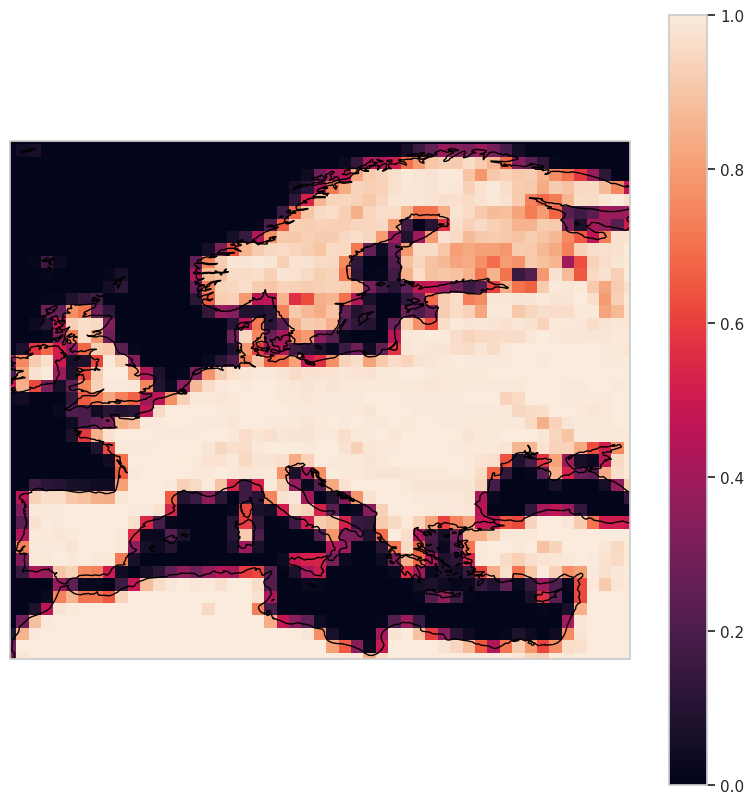

In [19]:
sea_mask = xr.open_dataset("/home/egauillard/data/ERA5_land_sea_mask_1deg.nc")

sea = sea_mask["lsm"].values


print(sea_mask["lsm"].dims)
print(sea.shape)

sea = sea_mask["lsm"].isel(time=0).values

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-10, 40, 30, 70])
contour = ax.pcolormesh(sea_mask["lsm"].longitude, sea_mask["lsm"].latitude, sea, transform=ccrs.PlateCarree())
plt.colorbar(contour)
plt.show()

('time', 'latitude', 'longitude')
(1, 180, 360)


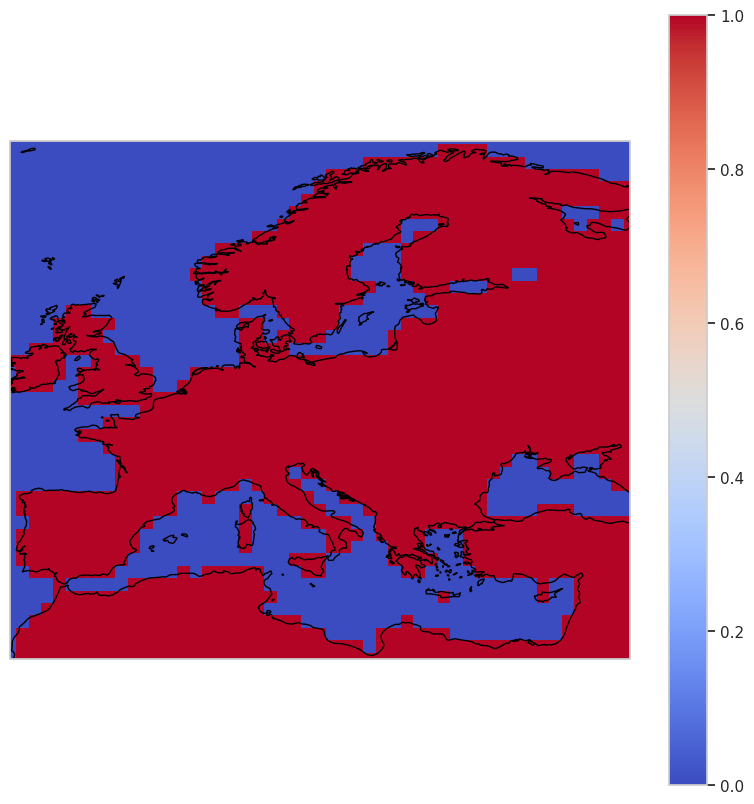

In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Charger le masque de mer
sea_mask = xr.open_dataset("/home/egauillard/data/ERA5_land_sea_mask_1deg.nc")

# Appliquer la transformation en binaire
threshold = 0.3
sea_mask["lsm"] = xr.apply_ufunc(
    lambda x: (x > threshold).astype(int),
    sea_mask["lsm"],
    dask="allowed",  # Si vous utilisez dask, sinon retirez cet argument
    keep_attrs=True  # Conserver les attributs
)

# Afficher les dimensions et la forme des données
print(sea_mask["lsm"].dims)
print(sea_mask["lsm"].shape)

# Tracer le masque de mer binaire
sea = sea_mask["lsm"].isel(time=0).values

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-10, 40, 30, 70])
contour = ax.pcolormesh(sea_mask["lsm"].longitude, sea_mask["lsm"].latitude, sea, transform=ccrs.PlateCarree(), cmap="coolwarm")
plt.colorbar(contour)
plt.show()


In [22]:
# Assurez-vous que les dimensions et les coordonnées correspondent
if not all(dim in ds.dims for dim in sea_mask["lsm"].dims):
    raise ValueError("Dimensions of ds and sea_mask do not match.")

tagret = ds.sel(time = "2010-01-01")

# Appliquer le masque sur les données de température
masked_tp = tagret['tp'][0].where(sea_mask["lsm"] == 0)
print(masked_tp)

# Calculer la moyenne selon les dimensions 'latitude' et 'longitude', tout en conservant la dimension 'time'
mean_tp = masked_tp.mean(dim=['latitude', 'longitude'])

print(mean_tp)
print(mean_tp.values)



<xarray.DataArray 'tp' (latitude: 15, longitude: 40, time: 1)>
array([[[           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [1.43093672e-02],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
...
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan

In [23]:
print(ds)

<xarray.Dataset>
Dimensions:    (time: 61586, bnds: 2, longitude: 50, latitude: 15)
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01T15:00:00 ... 2024-02-29T12:00:00
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 36.0 37.0 38.0 39.0
  * latitude   (latitude) float32 45.0 44.0 43.0 42.0 ... 34.0 33.0 32.0 31.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tp         (time, latitude, longitude) float32 0.002915 0.001254 ... 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Jul 04 11:00:15 2024: cdo cat PR_era5_MED_1degr_1940010...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...


In [25]:
data = ds.coarsen(latitude=5, longitude=5,boundary= "pad").mean()
# cartopy plot resolution for a certain day
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
data['tp'].sel(time='2000-01-01').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')
ax.coastlines()
plt.show()

AttributeError: Rectangle.set() got an unexpected keyword argument 'cmap'

In [31]:
ds["tp"]

<xarray.DataArray 'tp' (time: 61586, latitude: 15, longitude: 50)>
array([[[2.914679e-03, 1.253819e-03, ..., 2.794749e-06, 2.022182e-04],
        [3.855852e-03, 3.556881e-03, ..., 2.501847e-04, 1.139446e-03],
        ...,
        [2.685709e-02, 6.940624e-03, ..., 4.412308e-08, 0.000000e+00],
        [1.855940e-02, 4.144840e-03, ..., 0.000000e+00, 0.000000e+00]],

       [[8.880285e-03, 9.583008e-03, ..., 1.585070e-03, 2.355134e-03],
        [7.619237e-03, 1.097446e-02, ..., 4.235749e-03, 4.131723e-03],
        ...,
        [1.245165e-02, 3.841679e-03, ..., 0.000000e+00, 0.000000e+00],
        [3.469713e-03, 1.214769e-03, ..., 0.000000e+00, 0.000000e+00]],

       ...,

       [[8.830695e-04, 9.025141e-04, ..., 0.000000e+00, 0.000000e+00],
        [7.209274e-04, 5.747197e-04, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00]],

       [[5.650119e-03, 4.739309e-03, ..., 0.000000e+00, 0.000000e+00],
        [3.514404e-03, 4.312499e-03, ..., 9.873743e-08, 0.000000e+00],
        ...,
        [7.392396e-06, 2.059703e-07, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01T15:00:00 ... 2024-02-29T12:00:00
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 36.0 37.0 38.0 39.0
  * latitude   (latitude) float32 45.0 44.0 43.0 42.0 ... 34.0 33.0 32.0 31.0
Attributes:
    long_name:     Total precipitation
    units:         m
    cell_methods:  time: sum

<xarray.DataArray 'tp' (latitude: 15, longitude: 50)>
array([[1.016431e-02, 9.348191e-03, 9.819048e-03, ..., 1.800394e-05,
        4.457002e-06, 5.013285e-06],
       [1.154407e-02, 7.864778e-03, 6.395941e-03, ..., 1.221363e-04,
        1.581372e-04, 2.163275e-04],
       [1.628440e-02, 1.038391e-02, 5.197021e-03, ..., 2.836715e-04,
        1.808103e-04, 2.701951e-04],
       ...,
       [1.122404e-05, 8.631112e-07, 1.273396e-07, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.188126e-07, 9.090387e-08, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.898906e-07, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2008-01-01T12:00:00
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 36.0 37.0 38.0 39.0
  * latitude   (latitude) float32 45.0 44.0 43.0 42.0 ... 34.0 33.0 32.0 31.0
Attributes:
    long_name:     Total precipitation
    units:

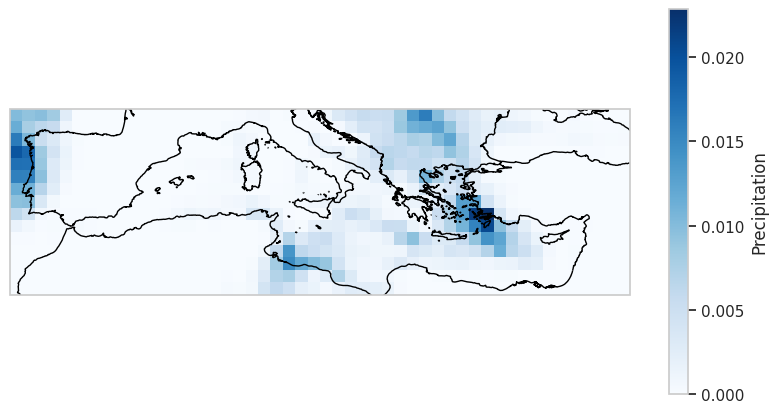

In [37]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
data = ds['tp'].sel(time='2008-01-01')
# select unique time 
data = data.isel(time=0)
print(data)
mesh = ax.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree(), cmap='Blues')
ax.coastlines()
plt.colorbar(mesh, ax=ax, label='Precipitation')
plt.show()

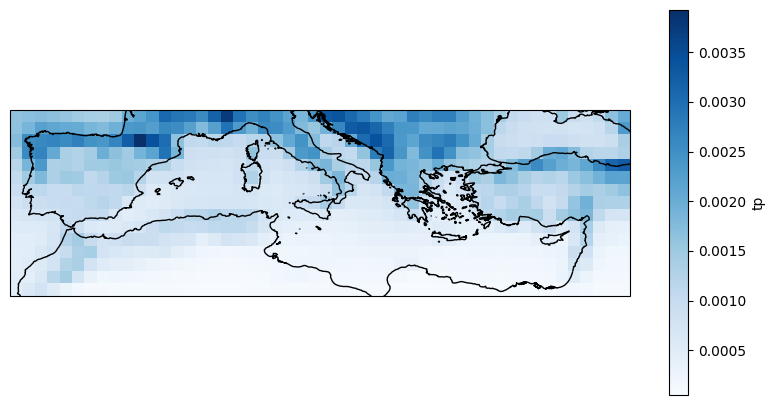

In [ ]:
# plot annual_mean
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
dry_season = [3, 4, 5, 6, 7, 8]
dry = ds.where(ds['time.month'].isin(dry_season))
dry['tp'].mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')
ax.coastlines()
plt.show()

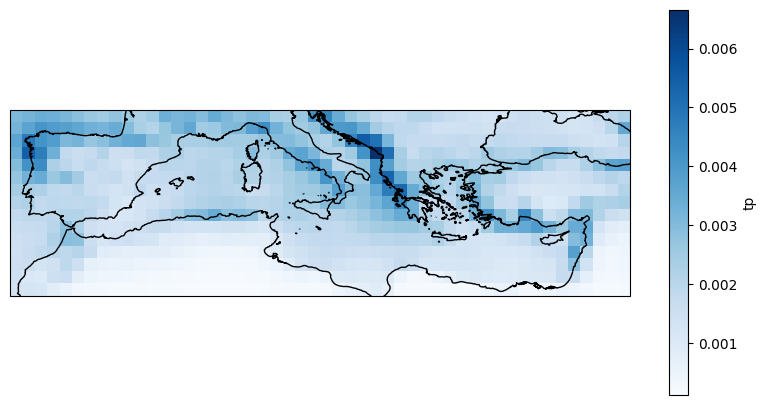

In [ ]:
#juster garder  la wet season et faire sur toutes les annees
wet_season = [10,11,12,1,2,3]
annual_mean = ds.where(ds.time.dt.month.isin(wet_season), drop=True)*1000

# plot annual_mean
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
annual_mean['tp'].mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')
ax.coastlines()
plt.show()


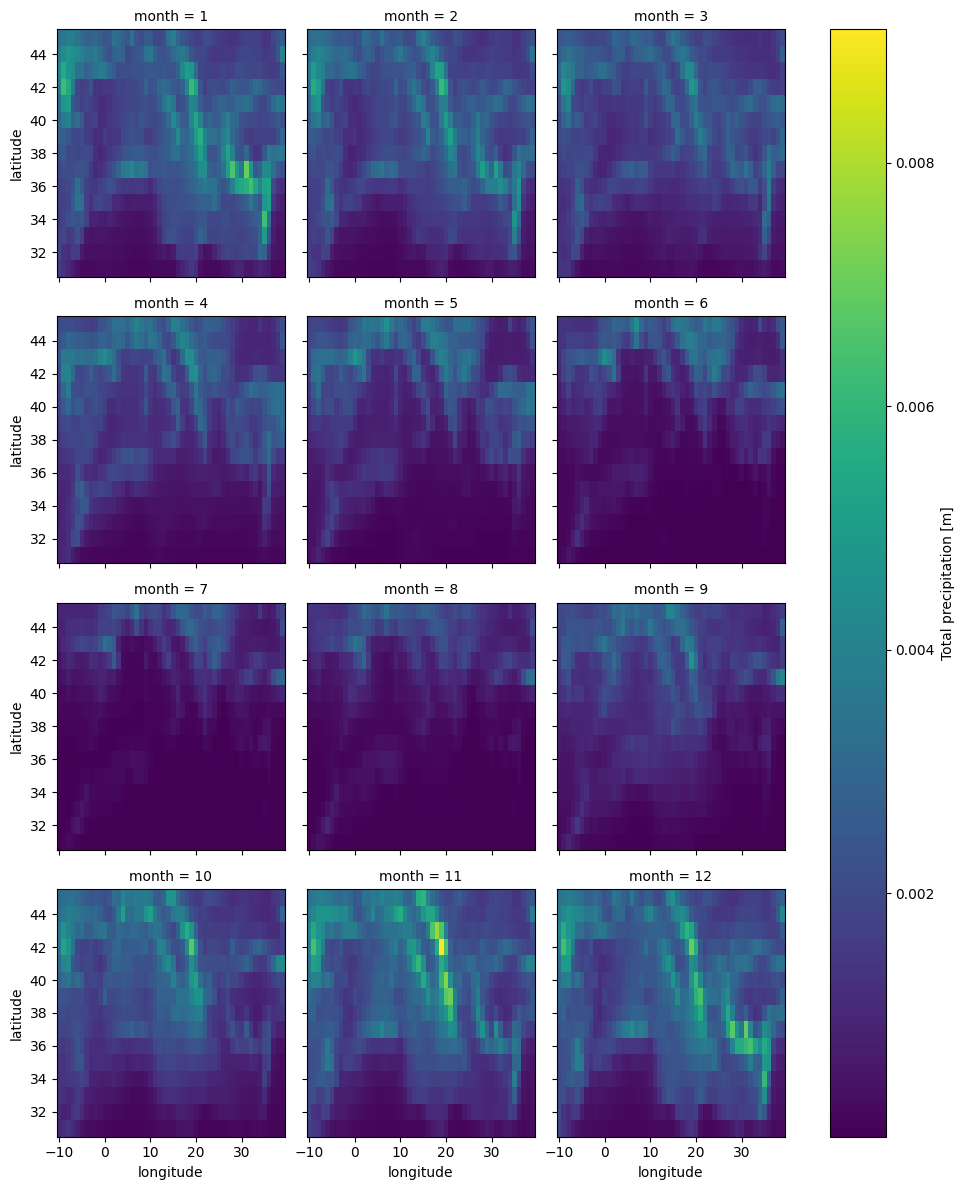

In [ ]:
ds['tp'].groupby('time.month').mean(dim='time').plot(col='month', col_wrap=3, cmap='viridis')
plt.show()

## 1- Distribution

                     time  bnds                     time_bnds  longitude  \
0     1940-01-01 15:00:00     0 1940-01-01 06:59:59.000000000       35.0   
1     1940-01-01 15:00:00     1 1940-01-01 23:59:59.000000000       35.0   
2     1940-01-02 12:00:00     0 1940-01-02 00:59:59.000000000       35.0   
3     1940-01-02 12:00:00     1 1940-01-02 23:59:59.000000000       35.0   
4     1940-01-03 12:00:00     0 1940-01-03 00:59:59.000000000       35.0   
...                   ...   ...                           ...        ...   
60791 2023-12-29 12:00:00     1 2023-12-29 23:59:59.000000512       35.0   
60792 2023-12-30 12:00:00     0 2023-12-30 00:59:59.000000512       35.0   
60793 2023-12-30 12:00:00     1 2023-12-30 23:59:59.000000512       35.0   
60794 2023-12-31 11:00:00     0 2023-12-31 00:59:59.000000512       35.0   
60795 2023-12-31 11:00:00     1 2023-12-31 22:59:59.000000512       35.0   

       latitude            tp  
0          31.0  0.000000e+00  
1          31.0  0.0000

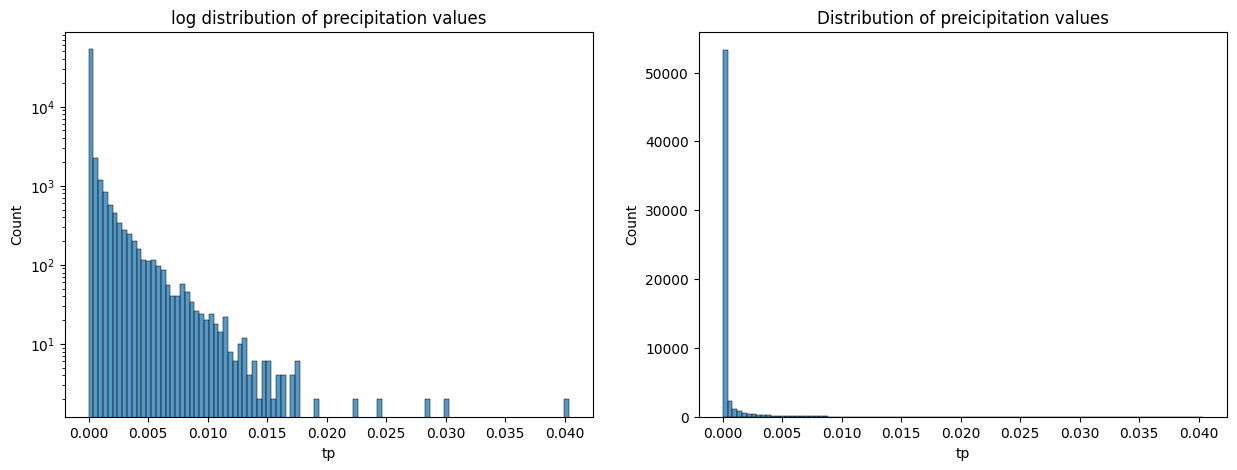

In [ ]:
selected_lat = 20
selected_lon = 35
cell_data = ds.sel(latitude=selected_lat, longitude=selected_lon, method='nearest')

df = cell_data.to_dataframe().reset_index()
print(df)
# Filtrer les valeurs proches de zéro pour améliorer la visualisation
# filtered_df = df[df['tp'] > 0.00001]
filtered_df = df

# Plot de la courbe de distribution des valeurs avec échelle logarithmique et sans l'échelle
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_yscale('log')
sns.histplot(filtered_df['tp'], bins=100, ax=ax[0])
ax[0].set_title('log distribution of precipitation values')

sns.histplot(filtered_df['tp'], bins=100, ax=ax[1])
ax[1].set_title('Distribution of preicipitation values')
plt.show()


                     time        tp
0     1940-01-01 15:00:00  0.002451
1     1940-01-02 12:00:00  0.003118
2     1940-01-03 12:00:00  0.004213
3     1940-01-04 12:00:00  0.002970
4     1940-01-05 12:00:00  0.002748
...                   ...       ...
30393 2023-12-27 12:00:00  0.000449
30394 2023-12-28 12:00:00  0.000452
30395 2023-12-29 12:00:00  0.000283
30396 2023-12-30 12:00:00  0.000335
30397 2023-12-31 11:00:00  0.000636

[30398 rows x 2 columns]


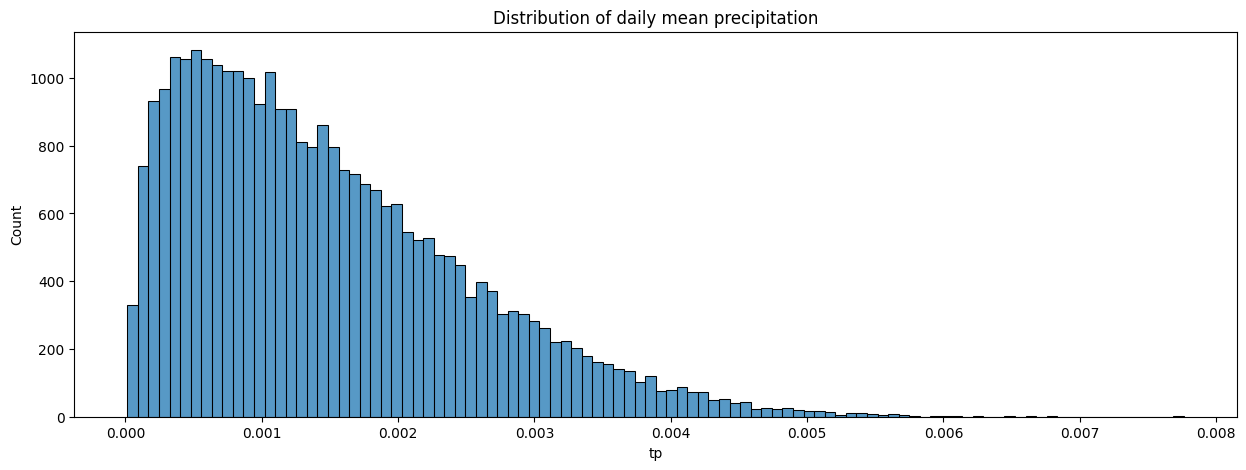

In [ ]:
#moyenne spatiale pour chaque jour
daily_mean = ds['tp'].mean(dim=['latitude', 'longitude'])

daily_mean_df = daily_mean.to_dataframe().reset_index()
print(daily_mean_df)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(daily_mean_df['tp'], bins=100 , ax=ax)

plt.title('Distribution of daily mean precipitation')
plt.show()

      month  latitude  longitude        tp
0         1      45.0      -10.0  0.003431
1         1      45.0       -9.0  0.003635
2         1      45.0       -8.0  0.003812
3         1      45.0       -7.0  0.003732
4         1      45.0       -6.0  0.003483
...     ...       ...        ...       ...
8995     12      31.0       35.0  0.000606
8996     12      31.0       36.0  0.000428
8997     12      31.0       37.0  0.000230
8998     12      31.0       38.0  0.000251
8999     12      31.0       39.0  0.000271

[9000 rows x 4 columns]


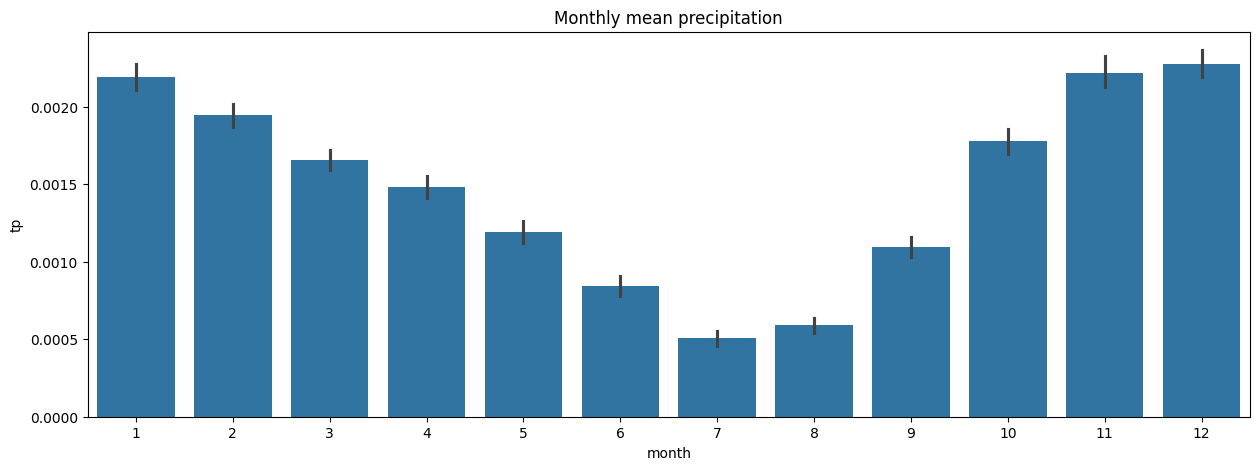

In [ ]:
# plot la moyenne par mois de preciipitation average sur toute la mediterannee
monthly_mean = ds['tp'].groupby('time.month').mean(dim='time')
monthly_mean_df = monthly_mean.to_dataframe().reset_index()
print(monthly_mean_df)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(data=monthly_mean_df, x='month', y='tp', ax=ax)
plt.title('Monthly mean precipitation')
plt.show()

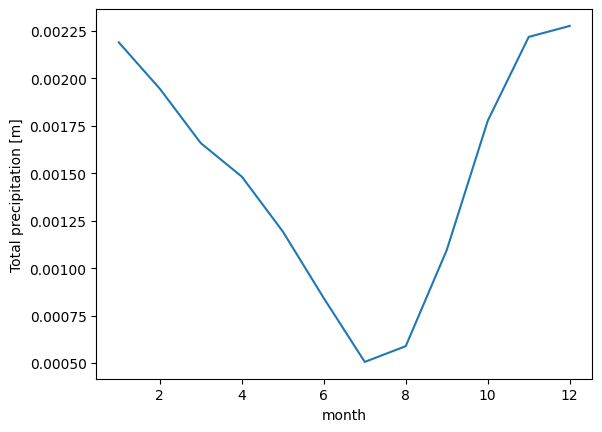

In [ ]:
month_mean = ds['tp'].groupby('time.month').mean(dim=['time','latitude', 'longitude'])
month_mean.plot()

KeyboardInterrupt: 

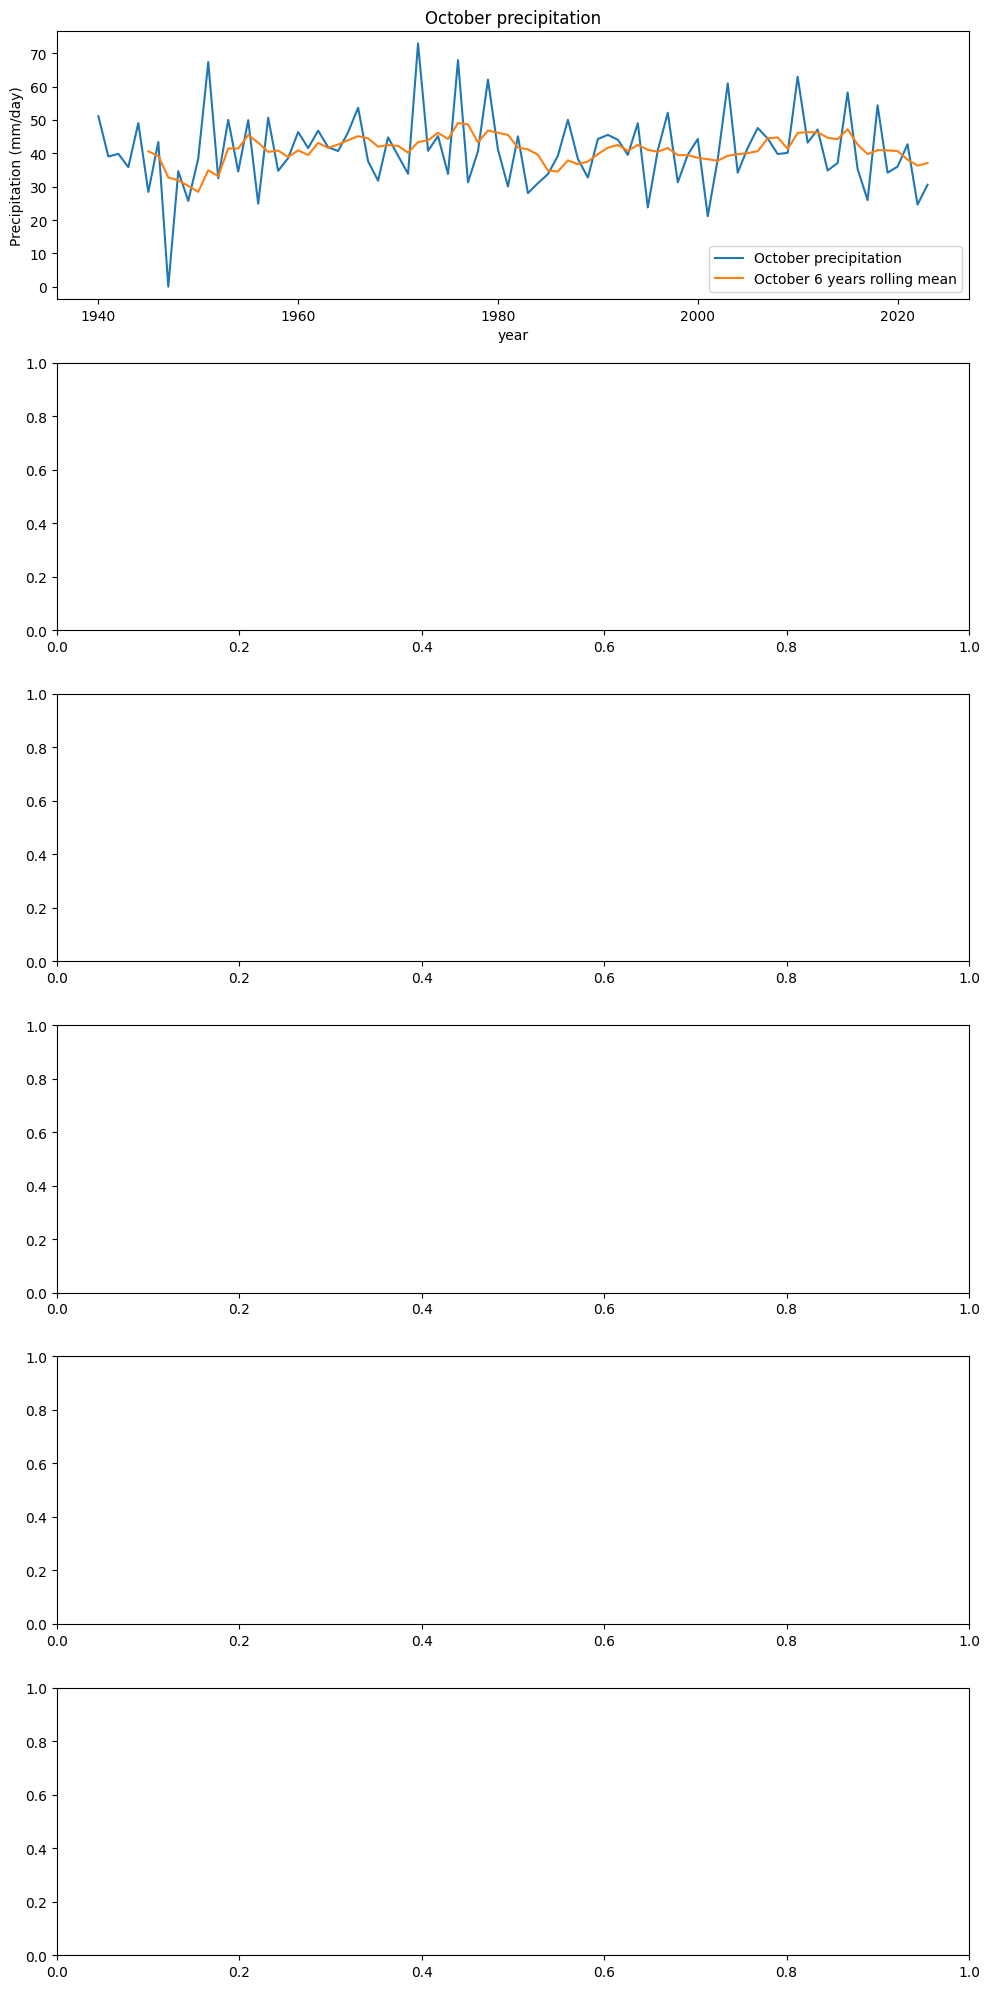

In [ ]:

# do this for all months in [10,11,12,1,2,3]
wet_season = [10,11,12,1,2,3]
month_maping = {1: 'January', 2: 'February', 3: 'March', 10: 'October', 11: 'November', 12: 'December'}
nb = len(wet_season)
fig, ax = plt.subplots(nb, 1, figsize=(10, 20))

for i, month in enumerate(wet_season):
    month_mean = ds['tp'].where(ds['time.month'] == month)
    # just do the sum not the mean
    month_mean = month_mean.groupby('time.year').sum(dim=['time', 'latitude', 'longitude'])
    rolling = month_mean.rolling(year=6).mean()
    month_mean_df = month_mean.to_dataframe().reset_index()
    sns.lineplot(data=month_mean_df, x='year', y='tp', ax=ax[i], label = f'{month_maping[month]} precipitation')
    sns.lineplot(data=rolling.to_dataframe().reset_index(), x='year', y='tp', ax=ax[i], label = f'{month_maping[month]} 6 years rolling mean')
    ax[i].set_title(f'{month_maping[month]} precipitation')
    ax[i].set_ylabel('Precipitation (mm/day)')
    # tight layout
    plt.tight_layout()

# figure titlt 

plt.suptitle('Wet season precipitation over mediterranean region')

plt.show()

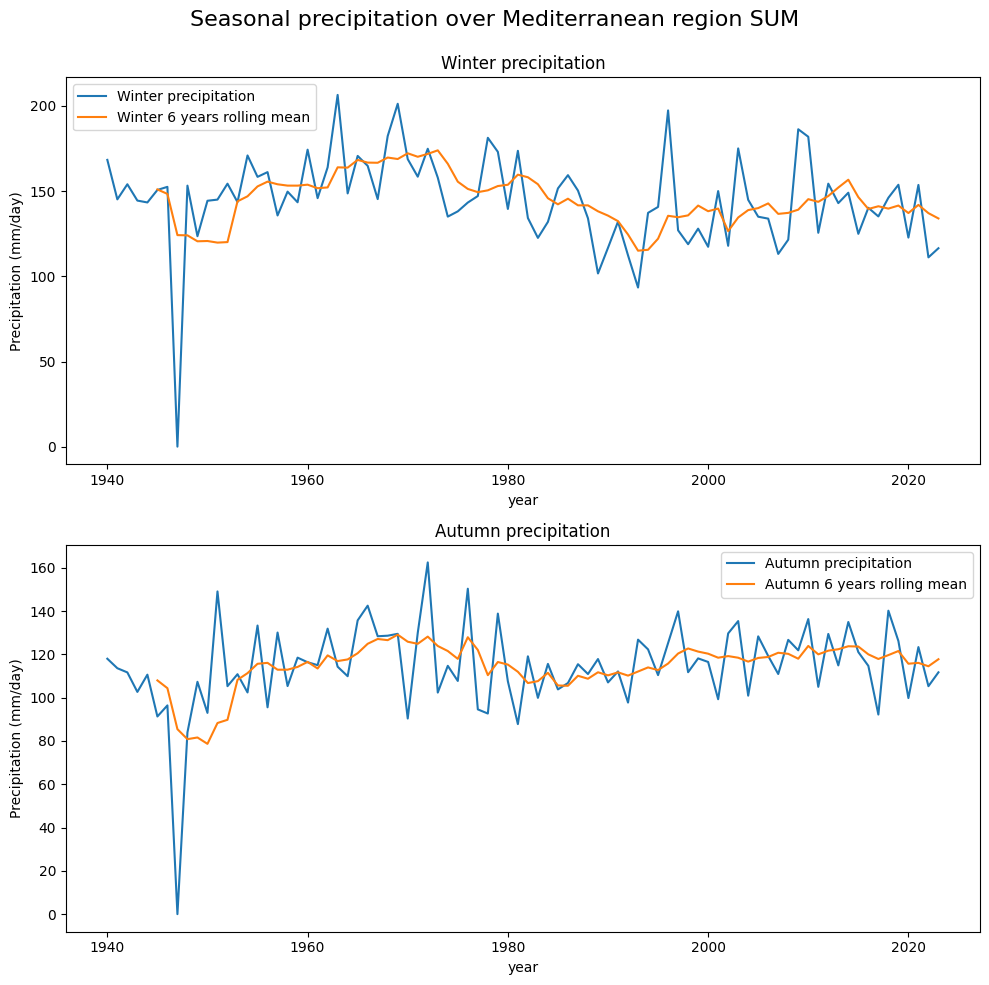

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
season_mapping = {'DJF': 'Winter', 'SON': 'Autumn'}

for i, season in enumerate(season_mapping.keys()):
    season_mean = ds['tp'].where(ds['time.season'] == season)
    season_mean = season_mean.groupby('time.year').sum(dim=['time', 'latitude', 'longitude'])
    rolling = season_mean.rolling(year=6).mean()
    season_mean_df = season_mean.to_dataframe().reset_index()
    
    sns.lineplot(data=season_mean_df, x='year', y='tp', ax=ax[i], label=f'{season_mapping[season]} precipitation')
    sns.lineplot(data=rolling.to_dataframe().reset_index(), x='year', y='tp', ax=ax[i], label=f'{season_mapping[season]} 6 years rolling mean')
    
    ax[i].set_title(f'{season_mapping[season]} precipitation')
    ax[i].set_ylabel('Precipitation (mm/day)')

# Adjust layout to make room for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.suptitle('Seasonal precipitation over Mediterranean region SUM', fontsize=16)
plt.show()


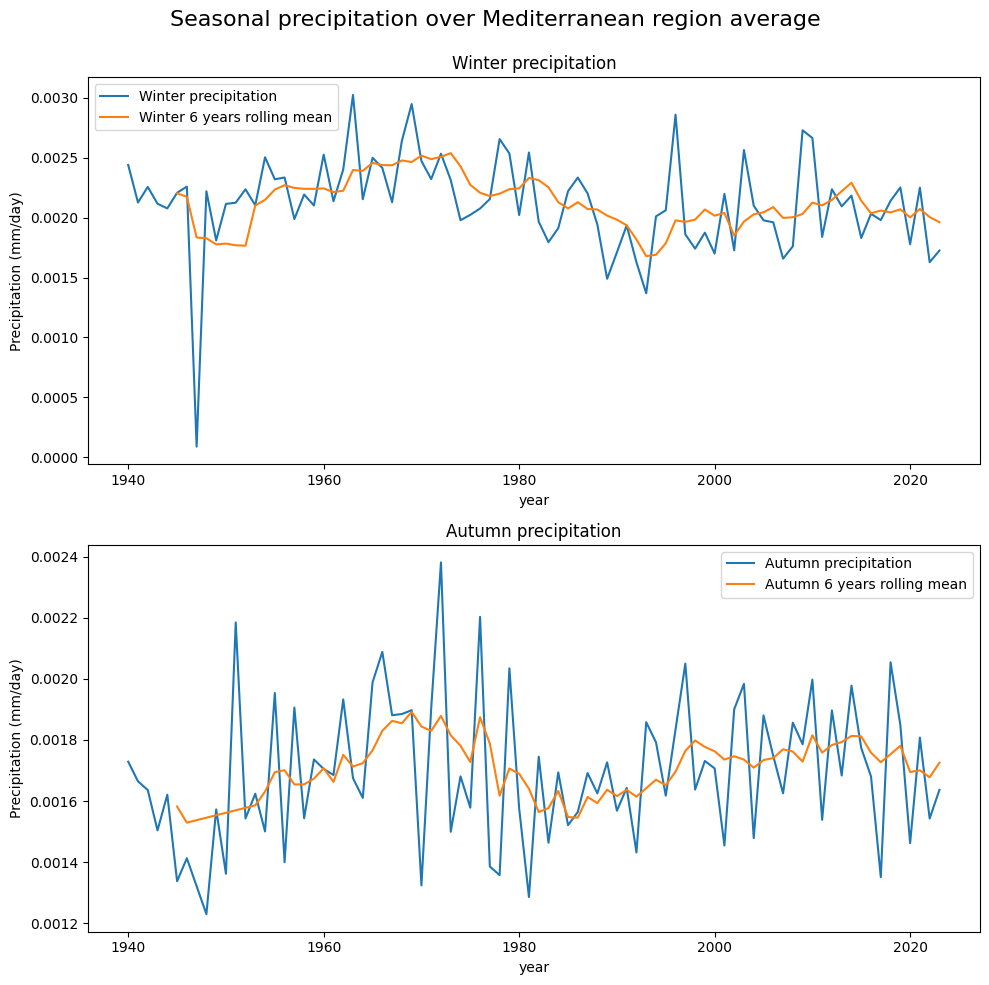

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
season_mapping = {'DJF': 'Winter', 'SON': 'Autumn'}

for i, season in enumerate(season_mapping.keys()):
    season_mean = ds['tp'].where(ds['time.season'] == season)
    season_mean = season_mean.groupby('time.year').mean(dim=['time', 'latitude', 'longitude'])
    rolling = season_mean.rolling(year=6).mean()
    season_mean_df = season_mean.to_dataframe().reset_index()
    
    sns.lineplot(data=season_mean_df, x='year', y='tp', ax=ax[i], label=f'{season_mapping[season]} precipitation')
    sns.lineplot(data=rolling.to_dataframe().reset_index(), x='year', y='tp', ax=ax[i], label=f'{season_mapping[season]} 6 years rolling mean')
    
    ax[i].set_title(f'{season_mapping[season]} precipitation')
    ax[i].set_ylabel('Precipitation (mm/day)')

# Adjust layout to make room for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.suptitle('Seasonal precipitation over Mediterranean region average', fontsize=16)
plt.show()

   year        tp
0  1940  0.002086
1  1941  0.001896
2  1942  0.001946
3  1943  0.001810
4  1944  0.001850
5  1945  0.001773
6  1946  0.001834
7  1947  0.000088
8  1948  0.001728
9  1949  0.001691


Text(0, 0.5, 'Precipitation (mm/day)')

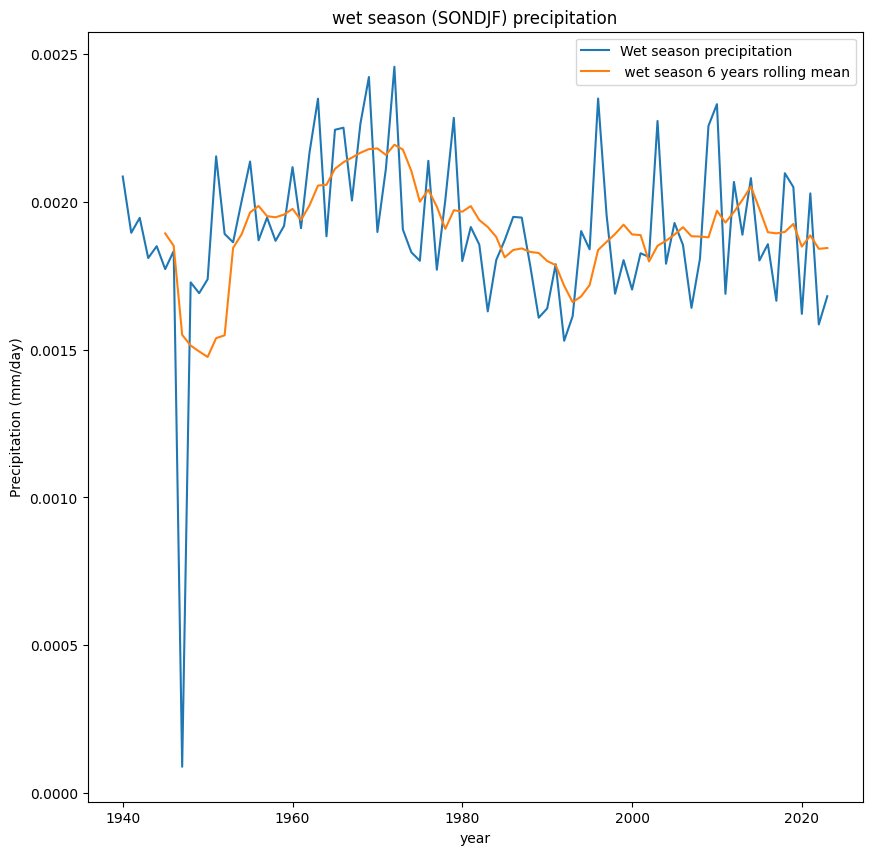

In [ ]:
# seaosnal precipitations on wet season
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
seasons = ['SON', 'DJF']
season_mapping = {'DJF': 'Winter', 'SON': 'Autumn'}

season_mean = ds['tp'].where(ds['time.season'].isin(seasons))
season_mean = season_mean.groupby('time.year').mean(dim=['time', 'latitude', 'longitude'])

rolling = season_mean.rolling(year=6).mean()
season_mean_df = season_mean.to_dataframe().reset_index()
print(season_mean_df.head(10))
sns.lineplot(data=season_mean_df, x='year', y='tp', ax=ax, label='Wet season precipitation')
sns.lineplot(data=rolling.to_dataframe().reset_index(), x='year', y='tp', ax=ax, label=' wet season 6 years rolling mean')

ax.set_title('wet season (SONDJF) precipitation')
ax.set_ylabel('Precipitation (mm/day)')




In [ ]:
year = 1930
year_mean = ds['tp'].groupby('time.year')
print(year_mean[1948])
# # plot the daily value over the lat lon
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# year_mean = year_mean.mean(dim=['latitude', 'longitude'])
# year_mean_df = year_mean.to_dataframe().reset_index()
# print(year_mean_df.head(10))
# sns.lineplot(data=year_mean_df, x='time', y='tp', ax=ax)
# plt.title(f'{year} precipitation')


<xarray.DataArray 'tp' (time: 367, latitude: 15, longitude: 50)> Size: 1MB
dask.array<getitem, shape=(367, 15, 50), dtype=float32, chunksize=(367, 15, 50), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 3kB 1948-01-01T12:00:00 ... 1948-12-31T2...
  * longitude  (longitude) float32 200B -10.0 -9.0 -8.0 -7.0 ... 37.0 38.0 39.0
  * latitude   (latitude) float32 60B 45.0 44.0 43.0 42.0 ... 33.0 32.0 31.0
Attributes:
    long_name:     Total precipitation
    units:         m
    cell_methods:  time: sum


In [ ]:
mean = ds['tp'].where(ds['time.month'] == 1)
mean_bis = mean.groupby('time.year').mean(dim=['time','latitude', 'longitude'])

x_train = np.array(mean_bis.year).reshape(-1,1)
print(x_train)
y_train = np.array(mean_bis)
print(y_train)

[[1940]
 [1941]
 [1942]
 [1943]
 [1944]
 [1945]
 [1946]
 [1947]
 [1948]
 [1949]
 [1950]
 [1951]
 [1952]
 [1953]
 [1954]
 [1955]
 [1956]
 [1957]
 [1958]
 [1959]
 [1960]
 [1961]
 [1962]
 [1963]
 [1964]
 [1965]
 [1966]
 [1967]
 [1968]
 [1969]
 [1970]
 [1971]
 [1972]
 [1973]
 [1974]
 [1975]
 [1976]
 [1977]
 [1978]
 [1979]
 [1980]
 [1981]
 [1982]
 [1983]
 [1984]
 [1985]
 [1986]
 [1987]
 [1988]
 [1989]
 [1990]
 [1991]
 [1992]
 [1993]
 [1994]
 [1995]
 [1996]
 [1997]
 [1998]
 [1999]
 [2000]
 [2001]
 [2002]
 [2003]
 [2004]
 [2005]
 [2006]
 [2007]
 [2008]
 [2009]
 [2010]
 [2011]
 [2012]
 [2013]
 [2014]
 [2015]
 [2016]
 [2017]
 [2018]
 [2019]
 [2020]
 [2021]
 [2022]
 [2023]]
[0.00271849 0.00264352 0.00259672 0.00262665 0.00147692 0.00288412
 0.00200795        nan 0.00248121 0.00183914 0.00214484 0.00241636
 0.0020939  0.00253416 0.00264    0.00248334 0.00220696 0.00190815
 0.0025355  0.00218527 0.00233002 0.00237978 0.00180855 0.00303246
 0.00160276 0.00253074 0.00287067 0.00196017 0.00246263 0.0

In [ ]:
mean_bis

<xarray.DataArray 'tp' (year: 84)> Size: 336B
dask.array<stack, shape=(84,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 672B 1940 1941 1942 1943 1944 ... 2020 2021 2022 2023
Attributes:
    long_name:     Total precipitation
    units:         m
    cell_methods:  time: sum

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.linear_model import LinearRegression
import pandas as pd 

class ClimatologyMonthlyLinearReg:
    def __init__(self, data: xr.DataArray, var: str, split_years: dict):
        self.data = data
        self.split_years = split_years
        self.var = var
        self.models = {}
        self.train_years = split_years["train"]
        self.test_years = split_years["test"]
        self.month_means = {month: self.get_average_by_month(month) for month in range(1, 13)}
        self.month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                         7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
        
        self._train_models()

    def get_average_by_month(self, month: int):
        month_data = self.data[self.var].where(self.data['time.month'] == month, drop=True)
        mean_data = month_data.groupby("time.year").mean(dim=['time', 'latitude', 'longitude'])
        return mean_data

    def _train_models(self):
        for month in range(1, 13):
            month_mean = self.month_means[month]
            self.train_years = [year for year in self.train_years if year in month_mean.year]
            train_data = month_mean.sel(year=self.train_years)
            x_train = np.array(train_data.year).reshape(-1, 1)
            y_train = np.array(train_data)
            model = LinearRegression()
            model.fit(x_train, y_train)
            self.models[month] = model

    def predict(self, year: int, month: int):
        if month in self.models:
            model = self.models[month]
            prediction = model.predict(np.array([[year]]))
            return prediction[0]
        else:
            raise ValueError("Model for month {} is not trained.".format(month))

    def evaluate(self):
        results = {}
        combined_data = []
        for month in range(1, 13):
            month_means = self.month_means[month]
            test_data = month_means.sel(year=self.test_years)
            x_test = np.array(test_data.year).reshape(-1, 1)
            y_test = np.array(test_data)

            if month in self.models:
                model = self.models[month]
                y_pred = model.predict(x_test)
                mse = np.mean((y_test - y_pred) ** 2)
                results[month] = {'y_test': y_test, 'y_pred': y_pred, 'mse': mse}
                
                for i, year in enumerate(self.test_years):
                    combined_data.append({'year': year, 'month': month, 'y_test': y_test[i], 'y_pred': y_pred[i]})
            else:
                results[month] = {'y_test': None, 'y_pred': None, 'mse': None}
        
        combined_df = pd.DataFrame(combined_data)
        combined_df['date'] = pd.to_datetime(combined_df[['year', 'month']].assign(day=1))
        combined_df = combined_df.sort_values('date')
        
        average_mse = np.mean([result['mse'] for result in results.values() if result['mse'] is not None])
        return results, average_mse, combined_df
    
    def plot_yearly_results(self):
        results, _, combined_df = self.evaluate()
        
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        x_test = combined_df['date']
        y_test = combined_df['y_test']
        y_pred = combined_df['y_pred']
        
        ax.plot(x_test, y_test, label='y_test', marker='o', color = 'purple')
        ax.plot(x_test, y_pred, label='y_pred', marker='x', color = 'orange')
        ax.set_title('Results on test set: ground truth vs predicted')
        ax.set_xlabel('Date')
        ax.set_ylabel(self.var)
        ax.legend()
        plt.show()


    def plot_test_results(self):
        results, _ , _= self.evaluate()
        
        fig, axs = plt.subplots(4, 3, figsize=(15, 20))
        axs = axs.flatten()
        
        for month in range(1, 13):
            result = results[month]
            if result['y_test'] is not None:
                x_test = self.month_means[month].sel(year=self.test_years).year
                y_test = result['y_test']
                y_pred = result['y_pred']
                
                ax = axs[month - 1]
                ax.plot(x_test, y_test, label='y_test', marker='o', color = 'purple')
                ax.plot(x_test, y_pred, label='y_pred', marker='x', color = 'orange')
                ax.set_title(f'Month {self.month_mapping[month]}')
                ax.set_xlabel('Year')
                ax.set_ylabel(self.var)
                ax.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.suptitle('Results on test set : ground truth vs predicted for every month', fontsize=16)
        plt.show()


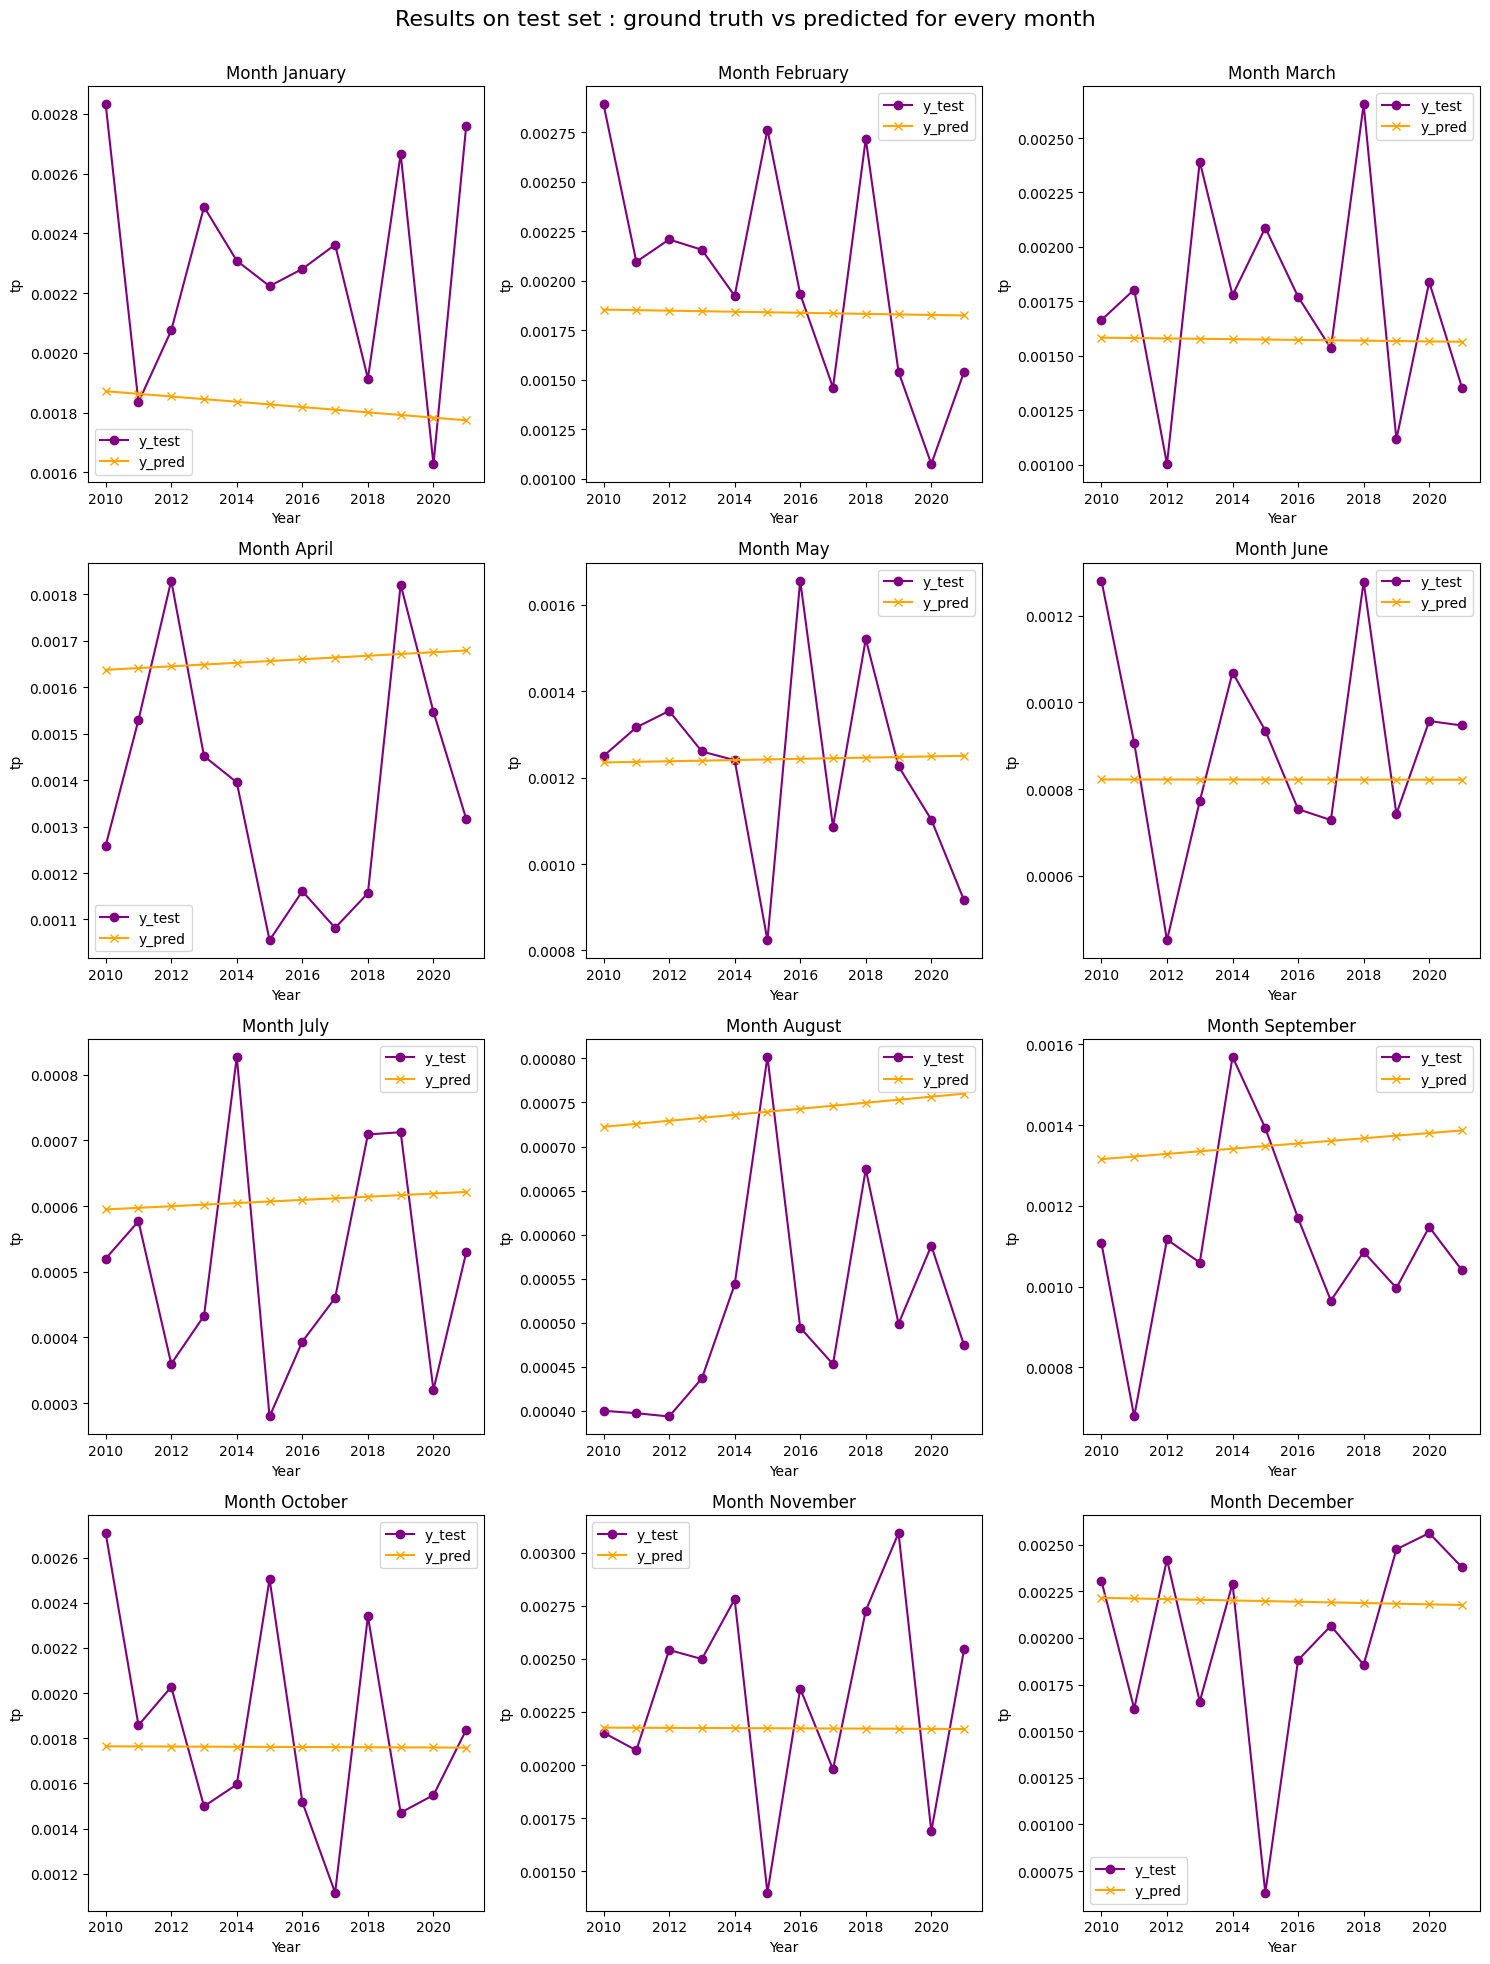

In [ ]:
climatology_month_models= ClimatologyMonthlyLinearReg(ds, 'tp', split_years={"train": list(range(1940, 2010)), "test": list(range(2010, 2022))})
climatology_month_models.plot_test_results()

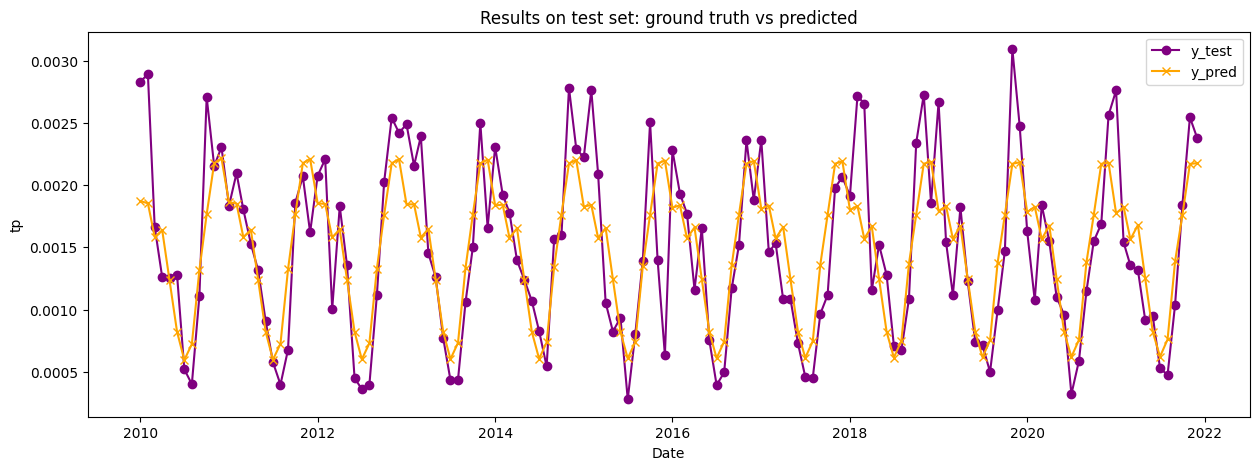

In [ ]:
climatology_month_models.plot_yearly_results()

In [ ]:
data_subset = ds.sel(time=ds['time.year'].isin([2022]))
# je veux dans data df pour chaque  année, toutes les moyennes de chaque mois de cette année
data_df = data_subset['tp'].groupby('time.year').mean(dim=['latitude', 'longitude']).to_dataframe().reset_index()


print(data_df.head(10))
data_df = data_df.reset_index().rename(columns={'year': 'year', 'month': 'month'})

ValueError: cannot reduce over dimensions ['time.month', 'latitude', 'longitude']. expected either '...' to reduce over all dimensions or one or more of FrozenMappingWarningOnValuesAccess(FrozenMappingWarningOnValuesAccess({'time': 366, 'bnds': 2, 'longitude': 50, 'latitude': 15})). Try passing .groupby(..., squeeze=False)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import xarray as xr
# from sklearn.linear_model import LinearRegression
# import pandas as pd

# class ClimatologyMonthlyLinearReg:
#     def __init__(self, data: xr.DataArray, var: str, split_years: dict):
#         self.data = data
#         self.split_years = split_years
#         self.var = var
#         self.train_years = split_years["train"]
#         self.test_years = split_years["test"]
#         self.model = None
        
#         self._train_model()

#     def _prepare_data(self, years):
#         data_subset = self.data.sel(time=self.data['time.year'].isin(years))
#         data_df = data_subset.groupby('time.year').mean(dim=['time', 'latitude', 'longitude']).to_dataframe()
#         print(data_df.head(10))
#         data_df = data_df.reset_index().rename(columns={'year': 'year', 'month': 'month'})
#         return data_df

#     def _train_model(self):
#         train_data = self._prepare_data(self.train_years)
#         train_data['month_sin'] = np.sin(2 * np.pi * train_data['month'] / 12)
#         train_data['month_cos'] = np.cos(2 * np.pi * train_data['month'] / 12)

#         x_train = train_data[['year', 'month_sin', 'month_cos']]
#         y_train = train_data[self.var]

#         self.model = LinearRegression()
#         self.model.fit(x_train, y_train)

#     def predict(self, year: int, month: int):
#         if self.model is not None:
#             month_sin = np.sin(2 * np.pi * month / 12)
#             month_cos = np.cos(2 * np.pi * month / 12)
#             prediction = self.model.predict(np.array([[year, month_sin, month_cos]]))
#             return prediction[0]
#         else:
#             raise ValueError("The model has not been trained.")

#     def evaluate(self):
#         test_data = self._prepare_data(self.test_years)
#         test_data['month_sin'] = np.sin(2 * np.pi * test_data['month'] / 12)
#         test_data['month_cos'] = np.cos(2 * np.pi * test_data['month'] / 12)

#         x_test = test_data[['year', 'month_sin', 'month_cos']]
#         y_test = test_data[self.var]
#         y_pred = self.model.predict(x_test)

#         results = {'y_test': y_test, 'y_pred': y_pred}
#         mse = np.mean((y_test - y_pred) ** 2)
        
#         return results, mse

#     def plot_yearly_results(self):
#         results, _ = self.evaluate()
        
#         test_data = self._prepare_data(self.test_years)
#         test_data['y_pred'] = results['y_pred']
#         test_data['index'] = pd.to_datetime(test_data[['year', 'month']].assign(day=1))

#         fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#         x_test = test_data['index']
#         y_test = test_data[self.var]
#         y_pred = test_data['y_pred']
        
#         ax.plot(x_test, y_test, label='y_test', marker='o', color='purple')
#         ax.plot(x_test, y_pred, label='y_pred', marker='x', color='orange')
#         ax.set_title('Results on test set: ground truth vs predicted')
#         ax.set_xlabel('Date')
#         ax.set_ylabel(self.var)
#         ax.legend()
#         plt.show()

#     def plot_test_results(self):
#         results, _ = self.evaluate()
        
#         test_data = self._prepare_data(self.test_years)
#         test_data['y_pred'] = results['y_pred']
#         test_data['index'] = pd.to_datetime(test_data[['year', 'month']].assign(day=1))

#         fig, axs = plt.subplots(4, 3, figsize=(15, 20))
#         axs = axs.flatten()

#         for month in range(1, 13):
#             month_data = test_data[test_data['month'] == month]
#             x_test = month_data['index']
#             y_test = month_data[self.var]
#             y_pred = month_data['y_pred']
            
#             ax = axs[month - 1]
#             ax.plot(x_test, y_test, label='y_test', marker='o', color='purple')
#             ax.plot(x_test, y_pred, label='y_pred', marker='x', color='orange')
#             ax.set_title(f'Month: {month}')
#             ax.set_xlabel('Date')
#             ax.set_ylabel(self.var)
#             ax.legend()
        
#         plt.tight_layout(rect=[0, 0, 1, 0.96])
#         plt.suptitle('Test Results: Actual vs Predicted for Each Month', fontsize=16)
#         plt.show()



In [ ]:
climatology = ClimatologyMonthlyLinearReg(ds, 'tp', split_years={"train": list(range(1940, 2010)), "test": list(range(2010, 2022))})

In [ ]:
results, average_mse = climatology.evaluate()

ValueError: too many values to unpack (expected 2)

In [ ]:
print(f"Average MSE: {average_mse}")

Average MSE: 1.6971262698445584e-07


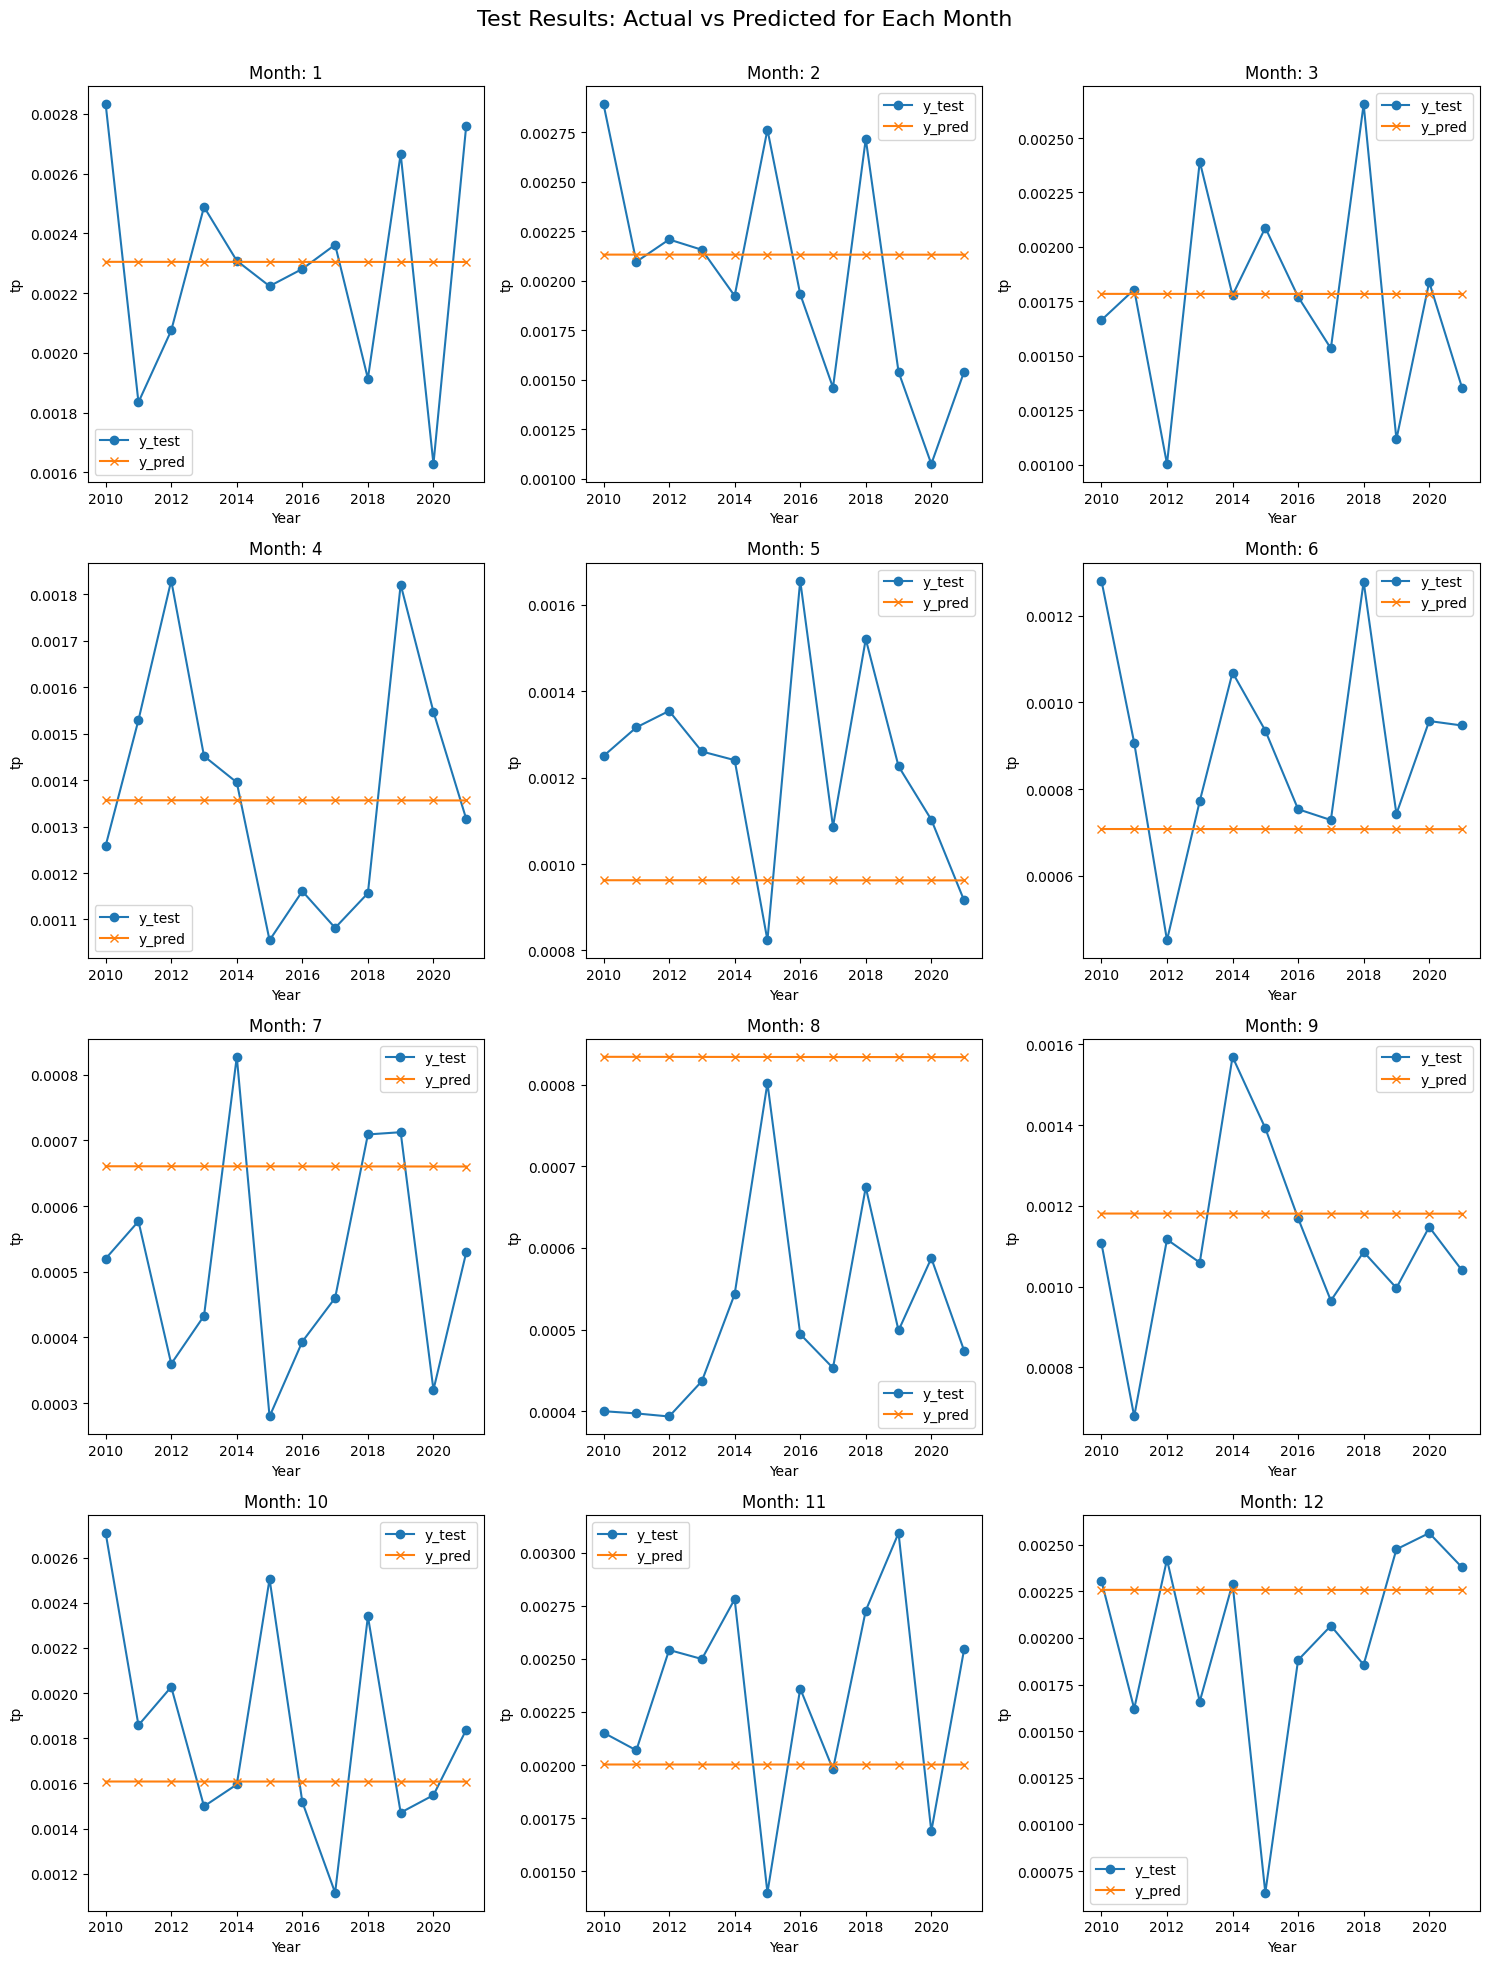

In [ ]:
climatology.plot_test_results()

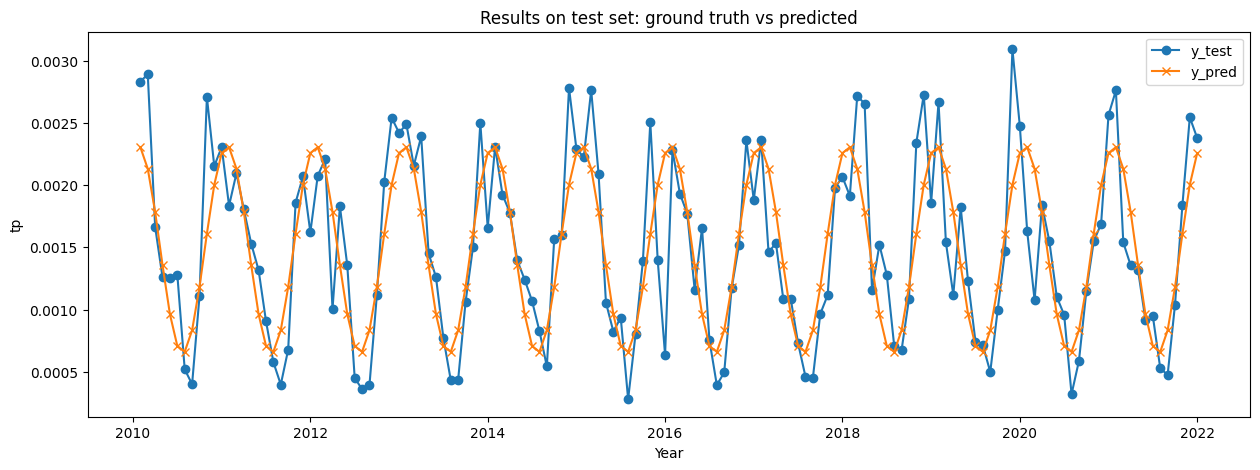

In [ ]:
climatology.plot_years_results()    

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

class ClimatologyARIMA:
    def __init__(self, data: xr.DataArray, var: str, split_years: dict):
        self.data = data
        self.split_years = split_years
        self.var = var
        self.train_years = split_years["train"]
        self.test_years = split_years["test"]
        self.month_means = {month: self.get_average_by_month(month) for month in range(1, 13)}
        self.month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                         7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
        self.model = None
        self.train_data = None
        self.test_data = None
        
        self._train_model()

    def get_average_by_month(self, month: int):
        month_data = self.data[self.var].where(self.data['time.month'] == month, drop=True)
        mean_data = month_data.groupby("time.year").mean(dim=['time', 'latitude', 'longitude'])
        return mean_data

    def _prepare_data(self, years):
        df_list = []
        for year in years:
            if year == 1947:
                continue
            else:
                for month in range(1, 13):
                    mean_data = self.month_means[month].sel(year=year).values
                    df_list.append({'year': year, 'month': month, self.var: mean_data})
            
        data = pd.DataFrame(df_list)
        data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
        data.set_index('date', inplace=True)
        return data
        
    def _train_model(self):
        print("prepare data")
        self.train_data = self._prepare_data(self.train_years)
        print(self.train_data)
        print("train data")
        self.model = ARIMA(self.train_data, order=(5, 1, 0))  # (p, d, q) order can be adjusted
        self.model = self.model.fit()

    def predict(self, steps: int):
        forecast = self.model.get_forecast(steps=steps)
        return forecast.predicted_mean

    def evaluate(self):
        self.test_data = self._prepare_data(self.test_years)
        steps = len(self.test_data)
        predictions = self.predict(steps)
        y_test = self.test_data.values
        y_pred = predictions.values
        
        mse = np.mean((y_test - y_pred) ** 2)
        results = {'y_test': y_test, 'y_pred': y_pred, 'mse': mse}
        
        return results

    def plot_test_results(self):
        results = self.evaluate()
        
        test_dates = self.test_data.index
        y_test = results['y_test']
        y_pred = results['y_pred']
        
        plt.figure(figsize=(12, 6))
        plt.plot(test_dates, y_test, label='y_test', marker='o')
        plt.plot(test_dates, y_pred, label='y_pred', marker='x')
        plt.title('Test Results: Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel(self.var)
        plt.legend()
        plt.show()


In [ ]:
arima = ClimatologyARIMA(ds, 'tp', split_years={"train": list(range(1940, 2010)), "test": list(range(2010, 2022))})



prepare data


KeyboardInterrupt: 

In [ ]:
arima.plot_test_results()